# **1) EXPLORATIVE DATA ANALYSIS**

---


In [ ]:
%%capture
!pip install -U spaCy
!python -m spacy download it_core_news_lg
!pip install transformers
!pip install datasets
!pip install evaluate

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import string
import re
import requests
import random
import os

# Graphics Libs
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 18, 8
import matplotlib.colors as mcolors
from wordcloud import WordCloud

# Pre-processing
import spacy
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
from nltk.corpus import stopwords

# Gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.tfidfmodel import TfidfModel
from gensim.corpora import Dictionary
from multiprocessing import cpu_count

# Models and utils
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm
import evaluate
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score

# Pytorch library for neural network
import torch
from torch import nn, optim
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print('Device is: ', str(device).upper())
from torch.utils.data import DataLoader

# HugginFace Utils
from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizer, BertModel

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/albertogvalerio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Device is:  MPS


In [77]:
BASE_PATHS = [
    # Base paths for training
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_1/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_2/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_3/',

    # Base paths for testing
    'https://cdn.albertovalerio.com/datasets/dankmemes/1_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/2_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/3_test/'
]

IMAGES_PATHS = [
    # Images paths for training
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_1/images_task1_train/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_2/images_task2_train/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_3/images_task3_train/',

    # Images paths for testing
    'https://cdn.albertovalerio.com/datasets/dankmemes/1_test/1_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/2_test/2_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/3_test/3_test/'
]

FILENAMES = [
    # Files for training
    'dankmemes_task1_train.csv',
    'dankmemes_task2_train.csv',
    'dankmemes_task3_train.csv',
    'dankmemes_task1_train_embeddings.csv',
    'dankmemes_task2_train_embeddings.csv',
    'dankmemes_task3_train_embeddings.csv',

    # Files for testing
    'meme_test_final.csv',
    'hate_test_final.csv',
    'event_test_final.csv',
    '1_test_embeddings.csv',
    '2_test_embeddings.csv',
    '3_test_embeddings_fixed.csv',

    # Utils
    'italian-swear-words-list_comma-separated-text-file.txt',
    'haspeede2_reference_taskAB-tweets.csv',

    # Testing task 2 with labels
    'hate_test_gold_standards.csv'
]

SAVED_MODELS = [
    # Trained on Dankmemes
    'https://cdn.albertovalerio.com/datasets/dankmemes/saved_models/bert_ita/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/saved_models/umberto/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/saved_models/feel_it/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/saved_models/roberta/',

    # Trained on Dankmemes + HaSpeeDe
    'https://cdn.albertovalerio.com/datasets/dankmemes/saved_models/bert_ita_plus/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/saved_models/umberto_plus/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/saved_models/feel_it_plus/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/saved_models/roberta_plus/'
]

In [3]:
task_1_train = pd.read_csv(BASE_PATHS[0] + FILENAMES[0])
task_2_train = pd.read_csv(BASE_PATHS[1] + FILENAMES[1])
task_3_train = pd.read_csv(BASE_PATHS[2] + FILENAMES[2])

task_1_test = pd.read_csv(BASE_PATHS[3] + FILENAMES[6])
task_2_test = pd.read_csv(BASE_PATHS[4] + FILENAMES[7])
task_3_test = pd.read_csv(BASE_PATHS[5] + FILENAMES[8])

task_2_standard = pd.read_csv(BASE_PATHS[4] + FILENAMES[14])

In [5]:
task_1_train.head()

,File,Engagement,Date,Manipulation,Visual,Text,Meme
0,0.jpg,11,2019-08-12,1,Salvini,satira cruda votaci.. saremo di parola il part...,1
1,1.jpg,2261,2019-08-21,0,0,"peccato per le accise, dai. c'eravamo quasi.",0
2,2.jpg,1327,2019-08-23,0,"Salvini, Di Maio","""che c'è ancora?"" ""aspetto un bambino""",1
3,3.jpg,18,2019-08-27,0,0,ora in onda speciale gr1 ascolta la diretta se...,0
4,4.jpg,617,2019-08-25,0,"Salvini, Di Maio",sta sciocchezza che sto pe fa e solo colpa tua,1


In [6]:
task_2_train.head()

,File,Engagement,Manipulation,Visual,Text,Hate Speech
0,1000.jpg,381,0,0,quando ti chiedono se sia peggiore fratelli d'...,1
1,1001.jpg,142,1,0,conte entra in un negozio di telefonia e passa...,0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",i politicanti italici non vedono l'ora di anda...,1
3,1003.jpg,165,1,"Salvini, Renzi",sono scemo. io di più. scemo & più scemo,1
4,1004.jpg,44,0,0,"beppe grillo (2017) genova, 21 luglio 1948 pol...",0


In [7]:
task_3_train.head()

,File,Engagement,Date,Macro,Manipulation,Visual,Text,Event
0,2000.jpg,994,2019-05-09,0,1,Lega,suca salvini rosica,0
1,2001.jpg,20,2019-08-29,0,0,0,"in nome del popolo italiano, i cittadini itali...",0
2,2002.jpg,15,2016-07-08,0,0,0,"vladimir, ti interessa l'affare immigrati? asc...",0
3,2003.jpg,9,2019-08-29,0,0,"Meloni, Mattarella","""ma come chi sono? presidè sò io senza fotosci...",2
4,2004.jpg,12,2019-01-31,0,0,0,"cos'era? un topo di fogna? ah...no, salvini.",0


In [8]:
task_2_standard.head()

,File,Engagement,Manipulation,Visual,Text,Hate Speech
0,5000.jpg,41,0,0,ogni singolo pensiero di salvini,1
1,5001.jpg,7,1,Salvini,per un nuovo governo: facile.it governare è fa...,0
2,5002.jpg,22,0,Lega,la lega a roma? e poi sarei io er monnezza! er...,1
3,5003.jpg,137,1,Conte,internazionale può funzionare un'alleanza tra ...,0
4,5004.jpg,2667,0,PD,esempi di cose che si autodistruggono,1


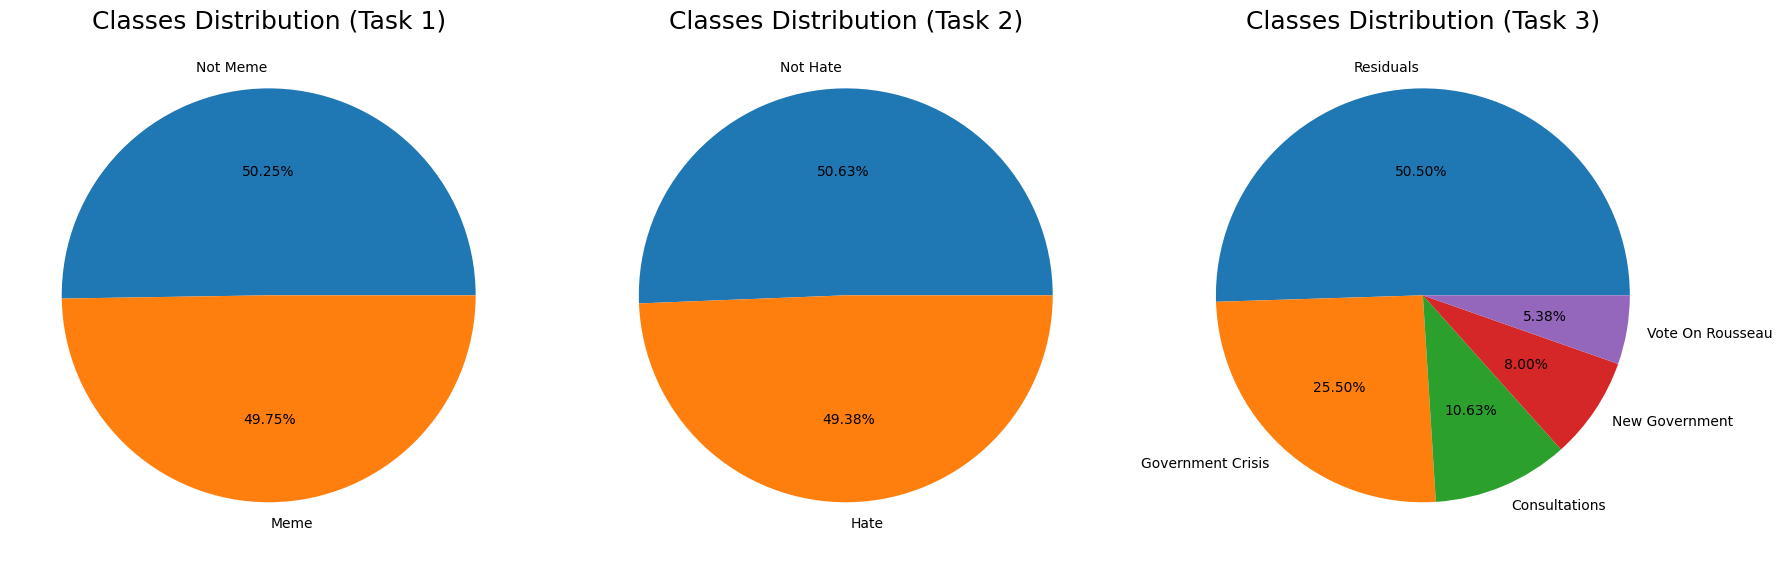

In [9]:
count1 = task_1_train['Meme'].value_counts()
count2 = task_2_train['Hate Speech'].value_counts()
count3 = task_3_train['Event'].value_counts()

labels1 = ['Not Meme', 'Meme']
labels2 = ['Not Hate', 'Hate']
labels3 = ['Residuals', 'Government Crisis', 'Consultations', 'New Government', 'Vote On Rousseau']

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 6))
ax1.pie(count1, labels=labels1, autopct = '%1.2f%%')
ax2.pie(count2, labels=labels2, autopct = '%1.2f%%')
ax3.pie(count3, labels=labels3, autopct = '%1.2f%%')
ax1.set_title('Classes Distribution (Task 1)', fontsize = 18)
ax2.set_title('Classes Distribution (Task 2)', fontsize = 18)
ax3.set_title('Classes Distribution (Task 3)', fontsize = 18)

plt.tight_layout()
plt.show()

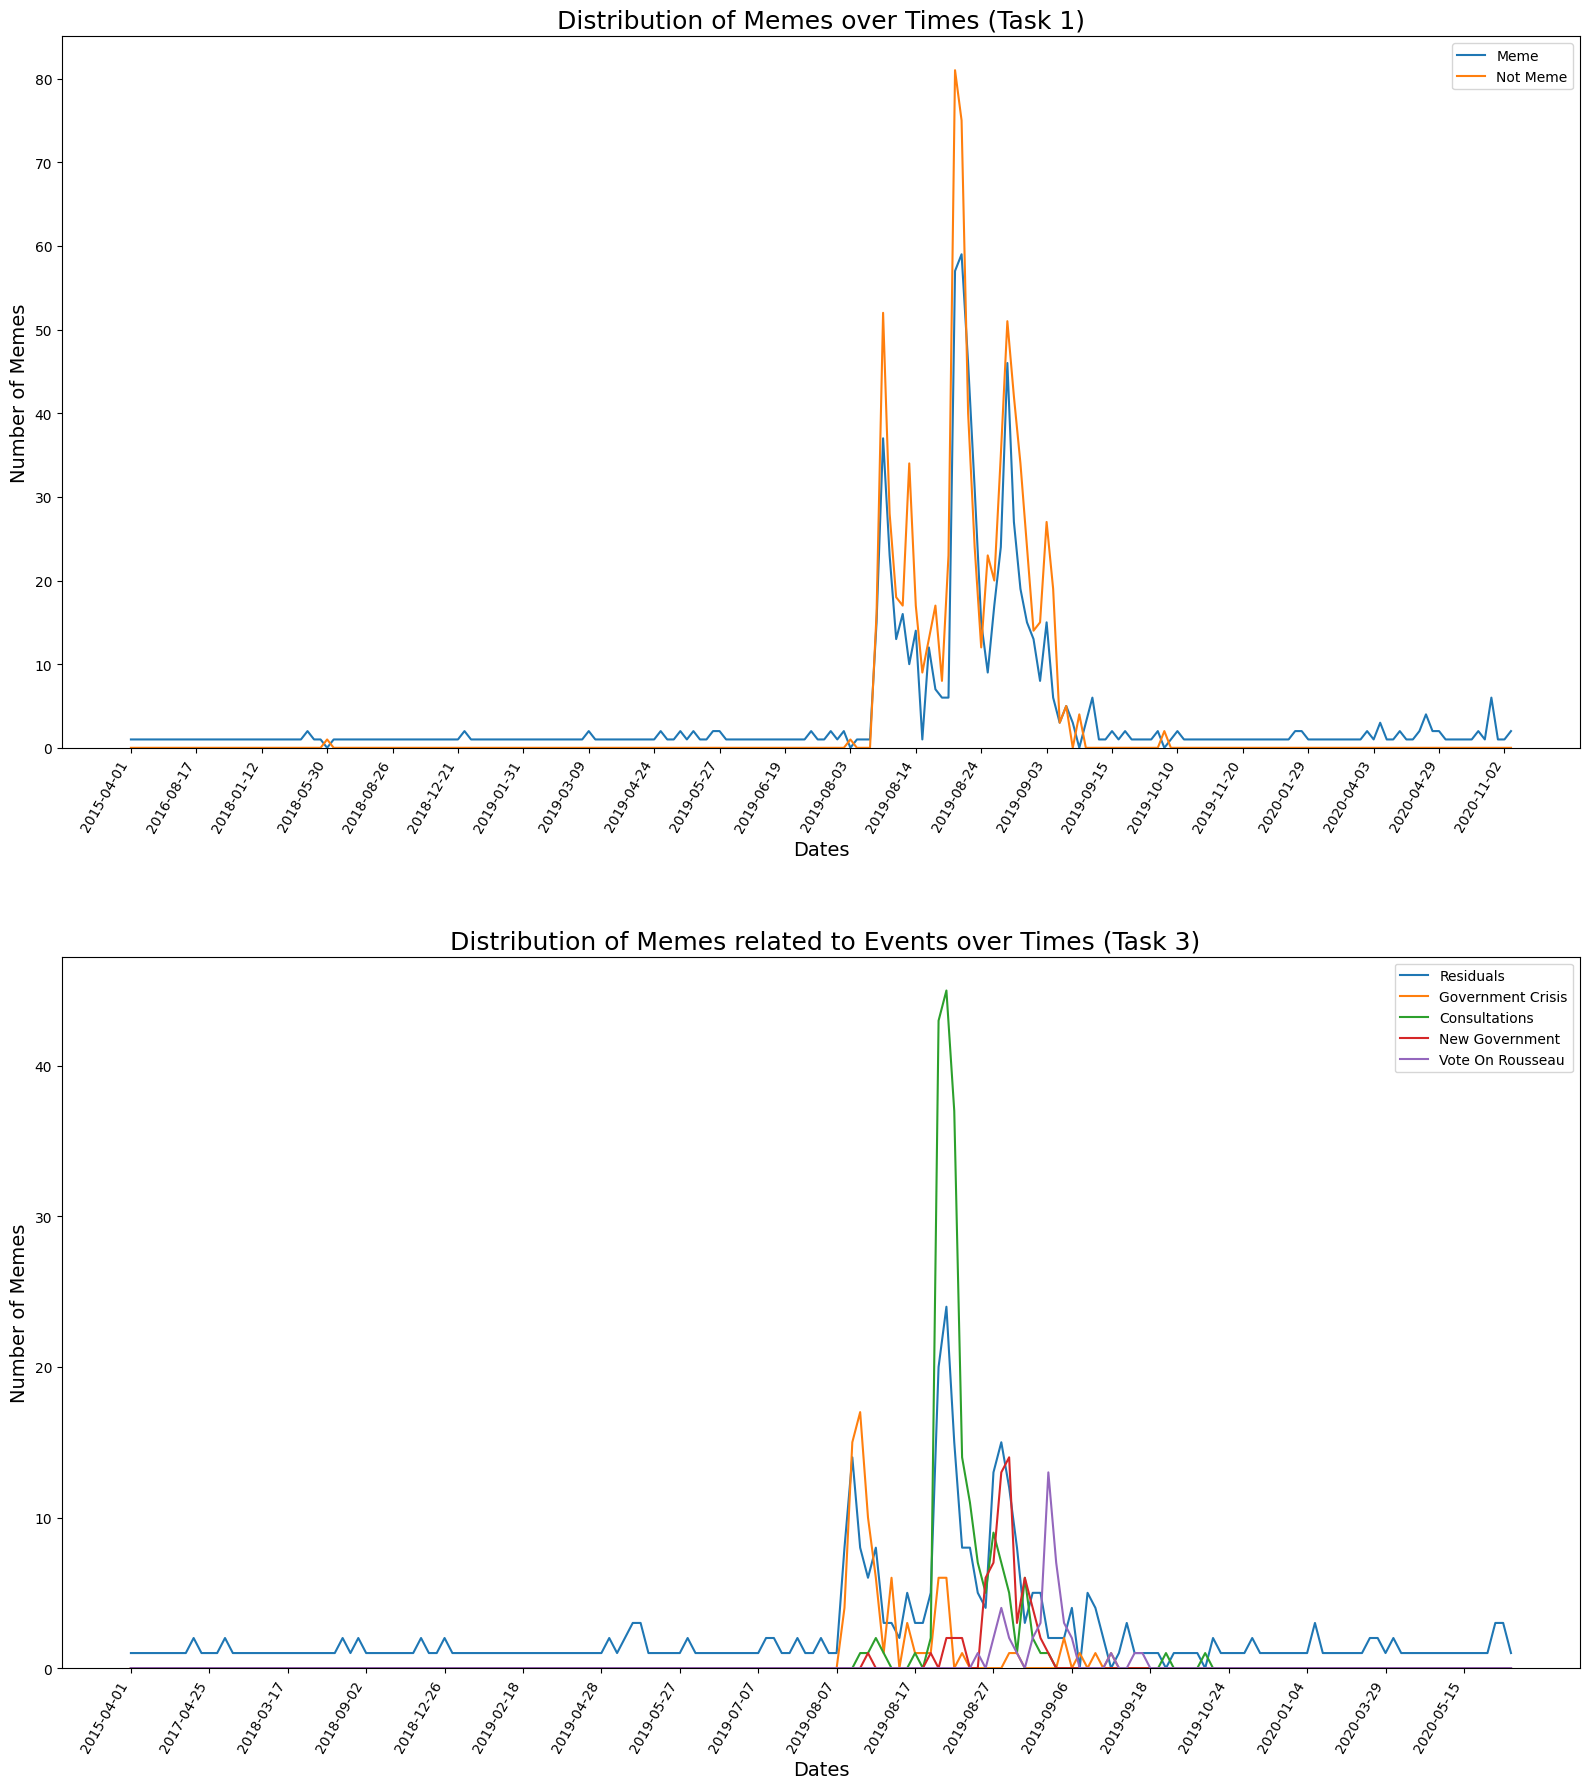

In [10]:
not_memes_by_date = task_1_train[task_1_train['Meme'] == 0].groupby('Date').size()
memes_by_date = task_1_train[task_1_train['Meme'] == 1].groupby('Date').size()
df1 = pd.DataFrame(index=pd.concat([not_memes_by_date, memes_by_date], axis=1).index, columns=['Meme','Not Meme'])
df1.loc[not_memes_by_date.index, 'Not Meme'] = not_memes_by_date.values
df1.loc[memes_by_date.index, 'Meme'] = memes_by_date.values
df1 = df1.sort_index()
df1 = df1.fillna(0)

class_0_by_date = task_3_train[task_3_train['Event'] == 0].groupby('Date').size()
class_1_by_date = task_3_train[task_3_train['Event'] == 1].groupby('Date').size()
class_2_by_date = task_3_train[task_3_train['Event'] == 2].groupby('Date').size()
class_3_by_date = task_3_train[task_3_train['Event'] == 3].groupby('Date').size()
class_4_by_date = task_3_train[task_3_train['Event'] == 4].groupby('Date').size()
df2 = pd.DataFrame(index=pd.concat([class_0_by_date, class_1_by_date, class_2_by_date, class_3_by_date, class_4_by_date], axis=1).index,
                   columns=['Residuals', 'Government Crisis', 'Consultations', 'New Government', 'Vote On Rousseau'])
df2.loc[class_0_by_date.index, 'Residuals'] = class_0_by_date.values
df2.loc[class_1_by_date.index, 'Government Crisis'] = class_1_by_date.values
df2.loc[class_2_by_date.index, 'Consultations'] = class_2_by_date.values
df2.loc[class_3_by_date.index, 'New Government'] = class_3_by_date.values
df2.loc[class_4_by_date.index, 'Vote On Rousseau'] = class_4_by_date.values
df2 = df2.sort_index()
df2 = df2.fillna(0)


fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(16, 18))
ax1.plot(df1.index, df1['Meme'], label='Meme')
ax1.plot(df1.index, df1['Not Meme'], label='Not Meme')
ax1.set_xlabel('Dates', fontsize = 14)
ax1.set_ylabel('Number of Memes', fontsize = 14)
ax1.set_xticks([df1.index[i] for i in range(0,len(df1.index),10)])
ax1.set_xticklabels([df1.index[i] for i in range(0,len(df1.index),10)], rotation = 60, ha="right")
ax1.set_ylim(ymin=0)
ax1.legend(loc='upper right')
ax1.set_title('Distribution of Memes over Times (Task 1)', fontsize = 18)
ax2.plot(df2.index, df2['Residuals'], label='Residuals')
ax2.plot(df2.index, df2['Government Crisis'], label='Government Crisis')
ax2.plot(df2.index, df2['Consultations'], label='Consultations')
ax2.plot(df2.index, df2['New Government'], label='New Government')
ax2.plot(df2.index, df2['Vote On Rousseau'], label='Vote On Rousseau')
ax2.set_xlabel('Dates', fontsize = 14)
ax2.set_ylabel('Number of Memes', fontsize = 14)
ax2.set_xticks([df2.index[i] for i in range(0,len(df2.index),10)])
ax2.set_xticklabels([df2.index[i] for i in range(0,len(df2.index),10)], rotation = 60, ha="right")
ax2.set_ylim(ymin=0)
ax2.legend(loc='upper right')
ax2.set_title('\n\n Distribution of Memes related to Events over Times (Task 3)', fontsize = 18)

plt.tight_layout()
plt.show()

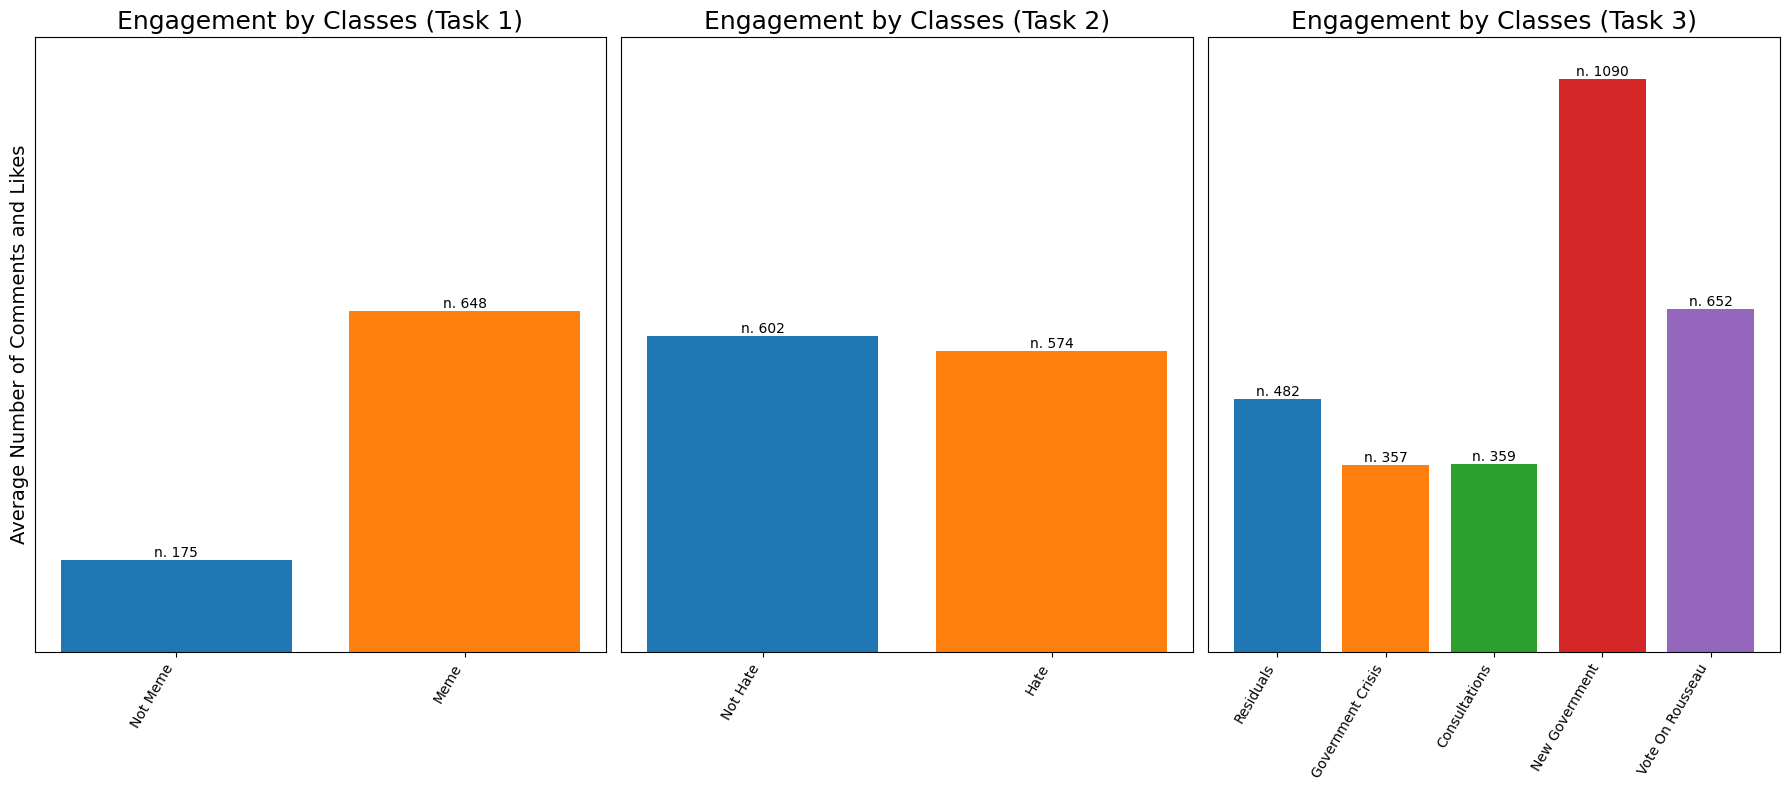

In [11]:
height1 = [
    task_1_train[task_1_train['Meme'] == 0]['Engagement'].mean(),
    task_1_train[task_1_train['Meme'] == 1]['Engagement'].mean()
]
height2 = [
    task_2_train[task_2_train['Hate Speech'] == 0]['Engagement'].mean(),
    task_2_train[task_2_train['Hate Speech'] == 1]['Engagement'].mean()
]
height3 = [
    task_3_train[task_3_train['Event'] == 0]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 1]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 2]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 3]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 4]['Engagement'].mean(),
]

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 8))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.bar(labels1, height=height1, color=colors)
ax1.set_ylabel('Average Number of Comments and Likes', fontsize = 14)
for rect in bars1:
     height = rect.get_height()
     ax1.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')
bars2 = ax2.bar(labels2, height=height2, color=colors)
for rect in bars2:
     height = rect.get_height()
     ax2.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')
bars3 = ax3.bar(labels3, height=height3, color=colors)
for rect in bars3:
     height = rect.get_height()
     ax3.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax1.set_title('Engagement by Classes (Task 1)', fontsize = 18)
ax2.set_title('Engagement by Classes (Task 2)', fontsize = 18)
ax3.set_title('Engagement by Classes (Task 3)', fontsize = 18)
ax1.set_ylim(ymin=0, ymax=(max(height3)+80))
ax2.set_ylim(ymin=0, ymax=(max(height3)+80))
ax3.set_ylim(ymin=0, ymax=(max(height3)+80))
ax1.set_xticklabels(labels1, rotation = 60, ha="right")
ax2.set_xticklabels(labels2, rotation = 60, ha="right")
ax3.set_xticklabels(labels3, rotation = 60, ha="right")
plt.tight_layout()
plt.show()

# **2) PRE-PROCESSING**

---


In [4]:
punctuations = string.punctuation
nlp = spacy.load("it_core_news_lg")
stop_words = stopwords.words('italian')

r = requests.get(BASE_PATHS[1] + FILENAMES[12])
swear_words = r.content.decode()

In [5]:
# This function convert a user censored bad word (i.e. "sei una m***a")
# with an equivalent one taken from a list of italian bad words
# according to the same initial and final uncesored letters and to the same POS tag (where possible!)
def get_explicit(censored):
    explicit = ''
    start = censored.split('*')[0] if '*' in censored else censored.split('x')[0]
    end = censored.split('*')[-1] if '*' in censored else censored.split('x')[-1]
    pattern = '\\b, '+start+'[a-z]*'+end+'\\b'
    all = ' '.join([w[2:] for w in re.findall(pattern, swear_words)])
    if all:
        options = [o for o in nlp(all)]
        options_tag_check = [o for o in nlp(all) if o.tag_ is nlp(censored)[0].tag_]
        if len(options_tag_check):
            explicit = random.choice(options_tag_check).text
        else:
            explicit = random.choice(options).text
    return explicit

In [6]:
def my_preprocessing(sentence, hashtag=False, explicit=True, lemmatization=True):

    #1 Normalization
    if hashtag:
        sentence = ' '.join(re.sub("@\w+|#\w+", "", sentence).split())

    if explicit:
        matches = re.findall('\w+\*+\w+|\w+x+\w+', sentence)
        for m in matches:
            sentence = sentence.replace(m, get_explicit(m))

    #2 Tokenization
    tokens = nlp(sentence)

    #3 Cleaning (removing punctuation and stop words)
    tokens = [ word.text for word in tokens ]
    tokens = [ word for word in tokens if word not in stop_words and word not in punctuations and "." not in word and "'" not in word ]
    tokens = [ word for word in tokens if len(word) > 2]

    #4 Lemmatization
    if lemmatization:
        tokens = [w.lemma_.lower() for w in nlp(' '.join(tokens))]

    return tokens

In [7]:
for i in task_2_train.sample(n=10)['Text']:
    print(f'{"ORIGINAL:":<20}{i}')
    print(f'{"PROCESSED:":<20}{my_preprocessing(i)}')
    print(f'{"NO_LEMMATIZATION:":<20}{my_preprocessing(i, lemmatization=False)}')
    print('\n')

ORIGINAL:           matteo salvini: la scienza da sola non basta, riapriamo le chiese. media italiani: attenzione, sta per dire qualcosa di stupido
PROCESSED:          ['matteo', 'salvini', 'scienza', 'solo', 'basta', 'riaprare', 'chiendere', 'media', 'italiano', 'attenzione', 'dire', 'qualcosa', 'stupido']
NO_LEMMATIZATION:   ['matteo', 'salvini', 'scienza', 'sola', 'basta', 'riapriamo', 'chiese', 'media', 'italiani', 'attenzione', 'dire', 'qualcosa', 'stupido']


ORIGINAL:           facci cognoscer lo tuo pensier: qual est lo miglior avvenire per lo paese? a allo voto subito, b alleanza/accrocchio di scopo fra inimici, c governo del presidente, d invasione dei lanzichenecchi con pestilenza al seguito
PROCESSED:          ['facci', 'cognoscer', 'pensier', 'qual', 'est', 'migliore', 'avvenire', 'paese', 'voto', 'subito', 'alleanza', 'accrocchio', 'scopo', 'fra', 'inimico', 'governo', 'presidente', 'invasione', 'lanzichenecco', 'pestilenza', 'seguire']
NO_LEMMATIZATION:   ['facci', 'cogn

# **3) FEATURES EXTRACTION**

---


In [8]:
data = task_2_train

## **Tokens**

In [9]:
data['Tokens'] = data['Text'].apply(lambda x:' '.join(my_preprocessing(x)))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Text', 'Tokens', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Text,Tokens,Hate Speech
423,1423.jpg,1,0,"Salvini, Conte",mo do le dimissioni poi t'aspetto fori,dimissione poi aspettare foro,1
633,1633.jpg,89,0,Conte,durante la più matta crisi della storia della ...,durante matto crisi storia repubblica ferie al...,0
331,1331.jpg,3,0,"Zingaretti, Renzi",chi t'ha dato 'sto fumo? dibba dar guatemala.....,dare fumo dibba dare guatemala convinto,0
693,1693.jpg,48,0,0,noio voulevon votar,noio voulevon votare,0
112,1112.jpg,3,0,Mattarella,me faccio vivo io,vivo,0
129,1129.jpg,75,0,Salvini,gamba di legno. braccio di ferro. testa di min...,gamba legno braccio ferro testa minchia,1
116,1116.jpg,12,0,"Mattarella, Berlusconi, Bernini, Gelmini, Tajani","...e poi gli ho detto: ""mattè, finché c'è figa...",poi dire mattè finché figo speranza sereno,1
370,1370.jpg,71,0,Conte,salsiccia o hamburger? sto in crisi,salsiccia hamburger crise,0
60,1060.jpg,18,0,0,italiano informato che mi ripete quali potrebb...,italiano informato ripetere quale potere esser...,0
564,1564.jpg,155,0,Salvini,san cazzaro da milano,san cazzaro milano,1


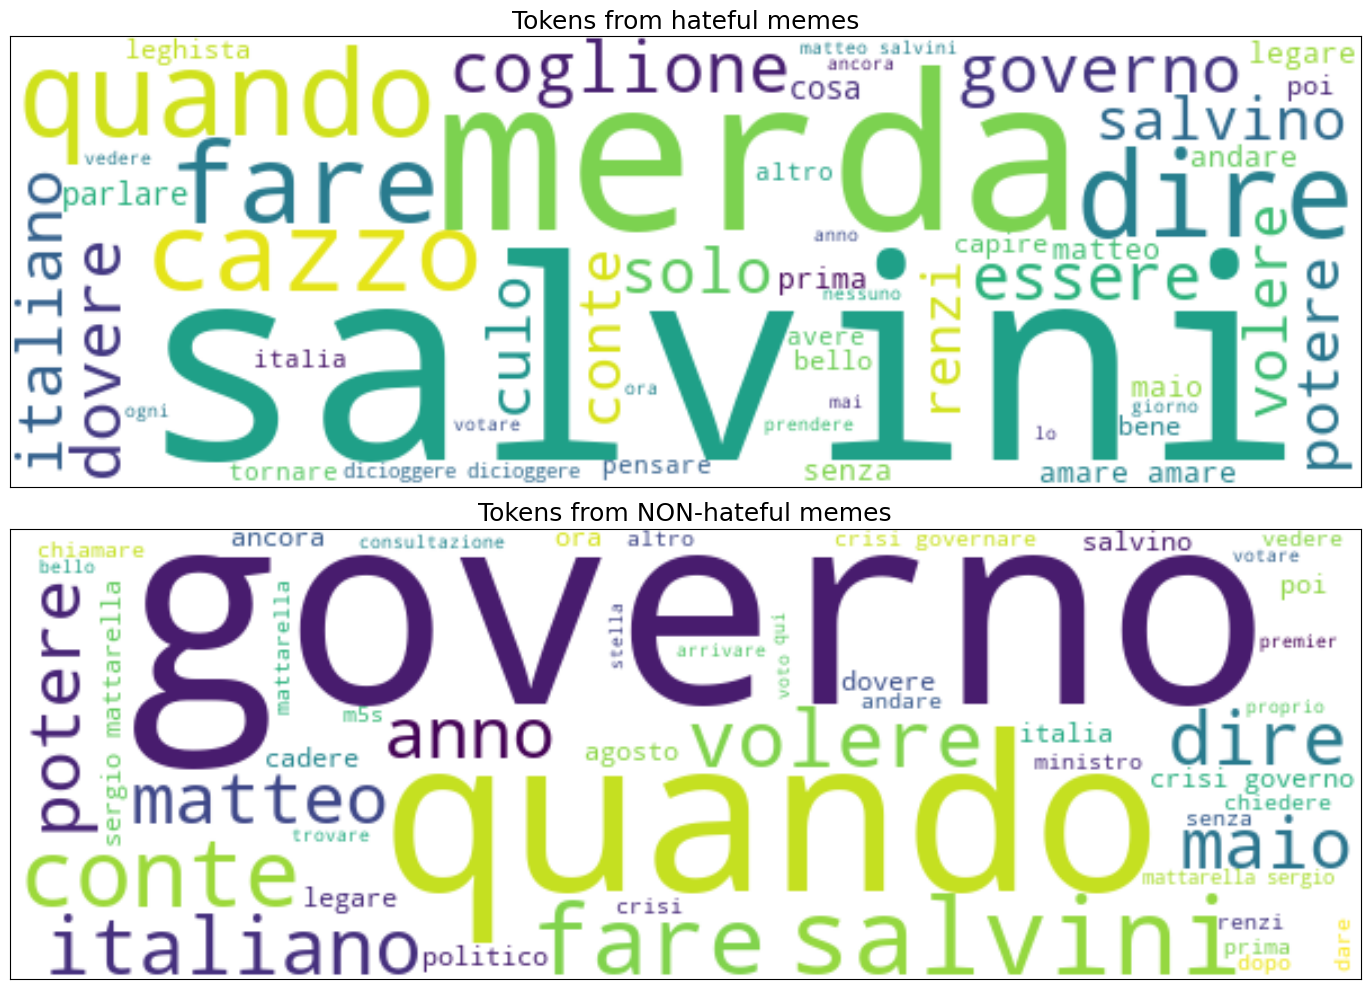

In [10]:
hateful_meme_tokens = data[data['Hate Speech']==1]['Tokens'].tolist()
nonhateful_meme_tokens = data[data['Hate Speech']==0]['Tokens'].tolist()
wordcloud_hate = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(hateful_meme_tokens))
wordcloud_not_hate = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(nonhateful_meme_tokens))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))
ax1.imshow(wordcloud_hate, interpolation='bilinear')
ax2.imshow(wordcloud_not_hate, interpolation='bilinear')
ax1.set_title('Tokens from hateful memes', fontsize = 18)
ax2.set_title('Tokens from NON-hateful memes', fontsize = 18)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()

## **Hate Score**

The hate score is given by the difference between the number of hate meme and the number of not hate meme for each of the people in 'Visual' column.

In [11]:
visuals = task_2_train['Visual']
people = []
for i in visuals:
    s = i.split(',')
    s = [j.strip() for j in s if j != ' ' and j != '']
    for e in s:
        if (e is not '0' and e.title() not in people):
            people.append(e.title())

df3 = pd.DataFrame(index=[p.title() for p in people], columns=['Hate Meme','Not Hate Meme','Hate Score'])
for p in people:
    all_by_person = task_2_train[task_2_train['Visual'].str.contains(p, case=False)]
    df3.loc[p, 'Hate Meme'] = 0-len(all_by_person[task_2_train['Hate Speech'] == 1])
    df3.loc[p, 'Not Hate Meme'] = len(all_by_person[task_2_train['Hate Speech'] == 0])
    df3.loc[p, 'Hate Score'] = len(all_by_person[task_2_train['Hate Speech'] == 0]) - len(all_by_person[task_2_train['Hate Speech'] == 1])

df3 = df3.sort_values('Hate Score')
df3.sample(n=10)

,Hate Meme,Not Hate Meme,Hate Score
Gentiloni,-2,1,-1
Prodi,-1,0,-1
Giannino,-1,0,-1
Boschi,-1,4,3
Tajani,-1,0,-1
Delrio,-1,0,-1
D'Alema,-3,0,-3
Cuperlo,-1,0,-1
Pd,-6,8,2
Di Battista,0,1,1


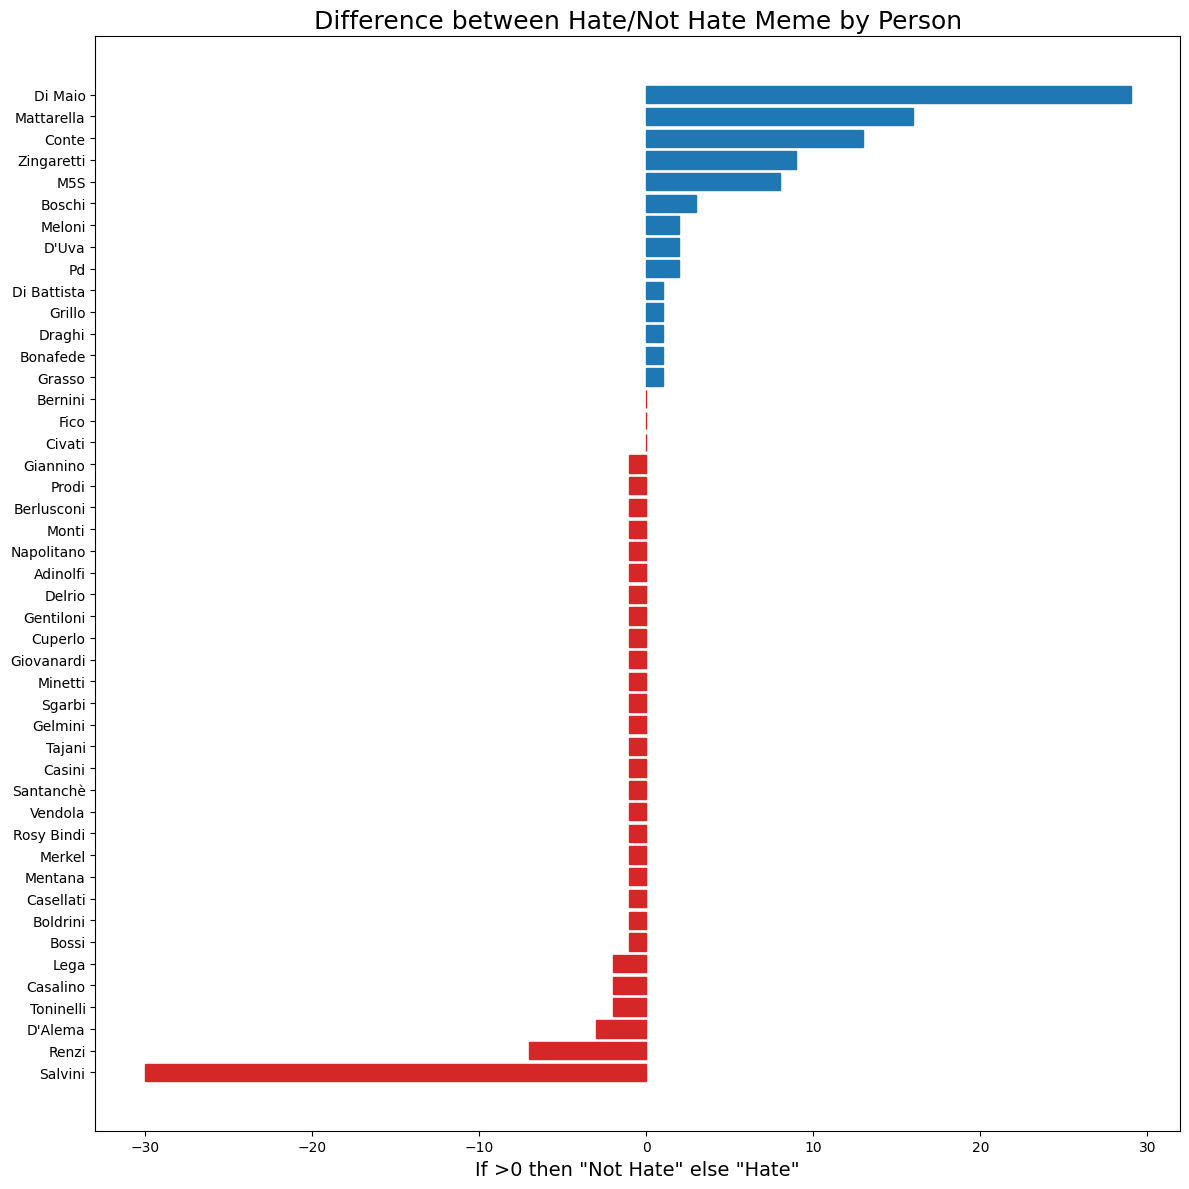

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.barh(df3.index, width=df3['Hate Score'], color=colors)
ax1.set_xlabel('If >0 then "Not Hate" else "Hate"', fontsize = 14)
for rect in bars1:
    width = rect.get_width()
    if (width > 0):
        rect.set_color('tab:blue')
    else:
        rect.set_color('tab:red')

ax1.set_title('Difference between Hate/Not Hate Meme by Person', fontsize = 18)
plt.tight_layout()
plt.show()

In [13]:
# The hate score is given by the difference between the number of
# hate meme and the number of not hate meme for each of the people in 'Visual' column
def get_hate_score(visual, score_df):
    score = np.NAN
    if (visual != '0'):
        visual = visual.split(',')
        visual = [j.strip().title() for j in visual if j != ' ' and j != '' and j != '0']
        score = score_df.loc[visual, 'Hate Score'].sum()
    return score

data['Hate Score'] = data['Visual'].apply(lambda x:get_hate_score(x, df3))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Hate Speech
387,1387.jpg,221,1,"Di Maio, Conte",42.0,quando tua mamma sta cazziando tuo fratello e ...,quando mamma cazziare fratello rimanare silenz...,1
304,1304.jpg,48,0,"Conte, Salvini",-17.0,corriere della sera mezz'ora di colloquio al q...,corriere sera ora colloquio quirinale conte di...,0
98,1098.jpg,334,1,0,NaN,che estate fantastica!,estate fantastico,0
677,1677.jpg,302,1,Berlusconi,-1.0,wish you were here,wish you were here,1
144,1144.jpg,84,1,M5S,8.0,stop bullismo! basta violenza sui siti che non...,stop bullismo bastare violenza sito funzionare,0
13,1013.jpg,486,0,Berlusconi,-1.0,erezioni subito,erezione subito,0
674,1674.jpg,17,1,0,NaN,detroit beco mentana,detroit beco mentano,0
129,1129.jpg,75,0,Salvini,-30.0,gamba di legno. braccio di ferro. testa di min...,gamba legno braccio ferro testa minchia,1
505,1505.jpg,26,0,Di Maio,29.0,quando l'italia crede che ti sia tirato indiet...,quando italia credere tirare indietro bene naz...,1
512,1512.jpg,630,0,0,NaN,il pd rappresentala vecchia politica il pd rub...,rappresentala vecchio politica rubare attaccar...,0


## **Number of Words**

The number of words calculated for the original 'Text' column's data.

In [14]:
data['Nr Words'] = data['Text'].apply(lambda x:len(str(x).split()))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Nr Words', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Nr Words,Hate Speech
653,1653.jpg,50,1,Meloni,2.0,bella pisè! ho ritrovato 'a sfera der drago ch...,bello pisè ritrovato sfera der drago regalare ...,15,0
538,1538.jpg,2844,0,Di Maio,29.0,dichiaro di aver letto e accettato i termini e...,dichiarare avere lere accettare termine condiz...,29,1
416,1416.jpg,65,1,"Salvini, Conte",-17.0,d'espresso li abbiamo cronometrati: è tutto ve...,esprimere cronometrato vero discorso fine gove...,52,1
76,1076.jpg,323,0,Mattarella,16.0,"""la crisi va risolta in tempi brevi. senza una...",crisi risolto tempo breve senza maggioranza so...,38,1
463,1463.jpg,502,0,0,NaN,"festa della mamma, salvini: ""auguri a tutte, m...",festa mamma salvini augurio tutto genitrice au...,27,1
614,1614.jpg,5,1,"Salvini, Lega",-32.0,lega salvini e tienilo legato,legare salvini tieniloere legato,5,0
25,1025.jpg,160,0,0,NaN,*orban ottiene i pieni poteri dal parlamento u...,orban ottenere pieno potere parlamento unghere...,15,1
240,1240.jpg,168,0,0,NaN,viaggiatore nel tempo: in che anno siamo? io: ...,viaggiatore tempo anno 2019 pieno crisi govern...,41,0
51,1051.jpg,17,0,"Salvini, Conte, Di Maio",12.0,salvini: ritiro la sfiducia conte: pijatela ne...,salvinie ritiro sfiducie conte pijatela culo,8,1
639,1639.jpg,125,0,"Salvini, Mattarella",-14.0,ti ho messo per ultimo sennò ti magnavi tutto ...,mettere ultimo sennò magnavi buffet,11,0


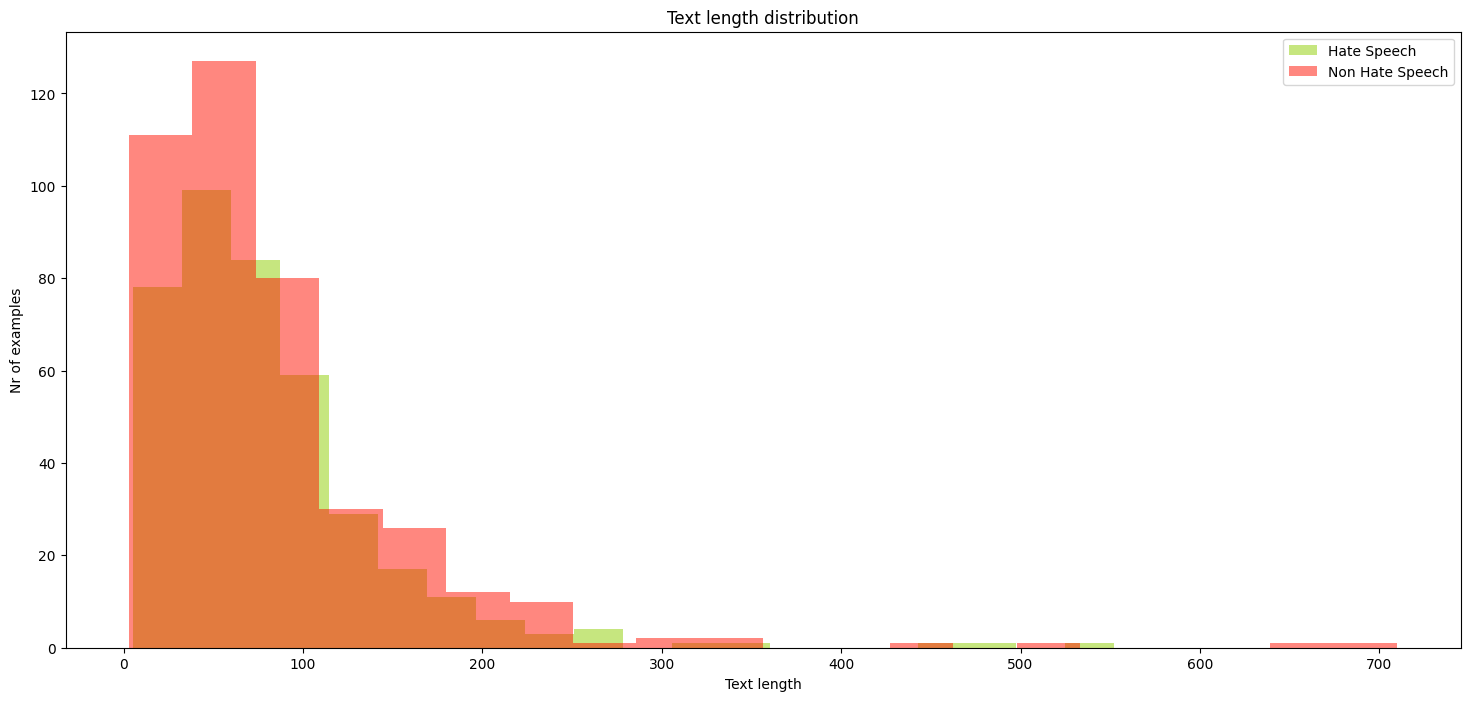

In [23]:
meme_dataset = data[data['Hate Speech'] == 1]
non_meme_dataset = data[data['Hate Speech'] == 0]
meme_dataset['Nr Words'] = meme_dataset['Text'].apply(len)
non_meme_dataset['Nr Words'] = non_meme_dataset['Text'].apply(len)
plt.hist(meme_dataset['Nr Words'], bins=20, alpha=0.5, label='Hate Speech', color='#8fce00')
plt.hist(non_meme_dataset['Nr Words'], bins=20, alpha=0.5, label='Non Hate Speech', color='#ff1100')
plt.xlabel('Text length')
plt.ylabel('Nr of examples')
plt.title('Text length distribution')
plt.legend()
plt.show()

## **Number of Tokens**

The number of words calculated for the 'Tokens' column's data.

In [15]:
data['Nr Tokens'] = data['Tokens'].apply(lambda x:len(str(x).split()))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Nr Words', 'Nr Tokens', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Nr Words,Nr Tokens,Hate Speech
421,1421.jpg,1376,0,0,NaN,ringrazio #libero per averci informati che car...,ringraziare libero avere ci informare carola r...,44,29,1
383,1383.jpg,163,1,"Salvini, Di Maio, Zingaretti",8.0,pnd,pnd,1,1,0
75,1075.jpg,23,0,"Berlusconi,",-1.0,"silvio berlusconi cari italiani, in questo mom...",silvio berlusconi caro italiano momento diffic...,22,14,1
715,1715.jpg,77,0,0,NaN,"leghista: ""sei un comunista di merda. salvini ...",leghista comunista merda salvini grande dovere...,25,15,1
28,1028.jpg,33,1,0,NaN,ecco il nuovo governo,ecco nuovo governo,4,3,0
153,1153.jpg,52,0,0,NaN,liberateci stocazzo,liberateci stocazzo,2,2,1
34,1034.jpg,37,1,Salvini,-30.0,salvini finalmente incontra lo stronzo che ha ...,salvini finalmente incontrare stronzo fare cad...,13,8,1
582,1582.jpg,29,0,0,NaN,oggi parleremo del bipolarismo di chi oggi vuo...,oggi parlare bipolarismo oggi volere crisi gov...,18,9,0
266,1266.jpg,476,0,"Conte, Salvini",-17.0,"""con le interferenze sui ministri hai minato l...",interferenza ministro minare azione governo co...,39,22,1
540,1540.jpg,5359,0,Mattarella,16.0,"basta, mi avete rotto tutti le palle. affido i...",bastare rompere palla affido governo palpatine...,15,8,1


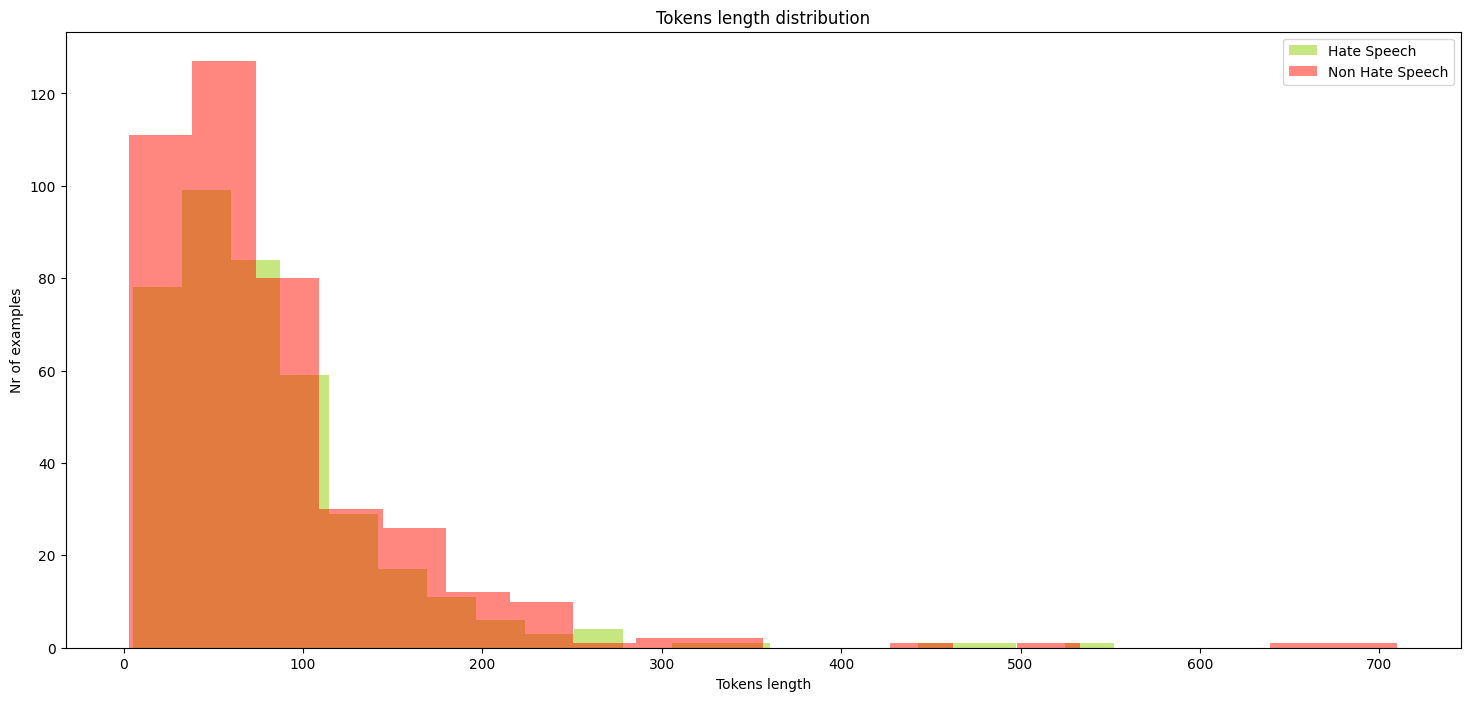

In [25]:
meme_dataset = data[data['Hate Speech'] == 1]
non_meme_dataset = data[data['Hate Speech'] == 0]
meme_dataset['Nr Tokens'] = meme_dataset['Text'].apply(len)
non_meme_dataset['Nr Tokens'] = non_meme_dataset['Text'].apply(len)
plt.hist(meme_dataset['Nr Tokens'], bins=20, alpha=0.5, label='Hate Speech', color='#8fce00')
plt.hist(non_meme_dataset['Nr Tokens'], bins=20, alpha=0.5, label='Non Hate Speech', color='#ff1100')
plt.xlabel('Tokens length')
plt.ylabel('Nr of examples')
plt.title('Tokens length distribution')
plt.legend()
plt.show()

## **NER**

In [16]:
tokens = data['Tokens']
df4 = pd.DataFrame(columns=['File Id','Entity Name','Entity Label'])
for t in tokens:
    spacy_tokens = nlp(t)
    if spacy_tokens.ents:
        names = []
        labels = []
        for ent in spacy_tokens.ents:
            names.append(ent.text)
            labels.append(ent.label_)
        list_row = [data[data['Tokens'] == t]['File'].iat[0], ', '.join(names), ', '.join(labels)]
        df4.loc[len(df4)] = list_row

df4.sample(n=10)

,File Id,Entity Name,Entity Label
73,1143.jpg,bibitaro san paolo,PER
263,1536.jpg,maria immacolato,PER
157,1329.jpg,salvini,MISC
40,1083.jpg,"venì cracovia, agnieszkao cia siergio","LOC, PER"
20,1035.jpg,italia,LOC
105,1224.jpg,italia,LOC
379,1788.jpg,pornhub livecams scopare adesso live sex premium,MISC
328,1676.jpg,"scusire, spaccimm chitemmuort","PER, PER"
383,1795.jpg,salvino,PER
125,1259.jpg,sbarco testa cazzo,MISC


## **Words Embedding**

### **Doc2Vec**

In [17]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data['Tokens'])]
d2v = Doc2Vec(vector_size=400, window=2, min_count=1)
d2v.build_vocab(documents)

In [18]:
data['Doc2Vec'] = data['Tokens'].apply(lambda x: d2v.infer_vector(x.split()))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Nr Words', 'Nr Tokens', 'Doc2Vec', 'Hate Speech']]
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Nr Words,Nr Tokens,Doc2Vec,Hate Speech
0,1000.jpg,381,0,0,NaN,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,15,8,"[-0.0008386693, -0.00017716929, 6.635085e-05, ...",1
1,1001.jpg,142,1,0,NaN,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,14,7,"[0.001138341, 0.00036347806, 0.0006839423, -0....",0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",7.0,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,17,10,"[-0.0007489962, -0.0011480692, 0.0010577926, 0...",1
3,1003.jpg,165,1,"Salvini, Renzi",-37.0,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,9,3,"[-0.0011344566, 0.0003991331, 8.74129e-05, 0.0...",1
4,1004.jpg,44,0,0,NaN,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,26,21,"[-0.0008205031, 0.00026731045, 0.0008487666, -...",0


### **TfIdf**

In [19]:
# Tokenizzazione dei testi
documents_tfidf = [text.split() for text in data['Text']]

# Creazione del dizionario dei token
dictionary = Dictionary(documents_tfidf)

# Creazione del corpus
corpus_tfidf = [dictionary.doc2bow(doc) for doc in documents_tfidf]

# Calcolo della rappresentazione TF-IDF
tfidf = TfidfModel(corpus_tfidf)

In [20]:
data['TfIdf'] = [ tfidf[t] for t in corpus_tfidf ]
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Nr Words', 'Nr Tokens', 'Doc2Vec', 'TfIdf', 'Hate Speech']]
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Nr Words,Nr Tokens,Doc2Vec,TfIdf,Hate Speech
0,1000.jpg,381,0,0,NaN,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,15,8,"[-0.0008386693, -0.00017716929, 6.635085e-05, ...","[(0, 0.323982732233108), (1, 0.323982732233108...",1
1,1001.jpg,142,1,0,NaN,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,14,7,"[0.001138341, 0.00036347806, 0.0006839423, -0....","[(13, 0.16049350282905558), (14, 0.20003469684...",0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",7.0,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,17,10,"[-0.0007489962, -0.0011480692, 0.0010577926, 0...","[(15, 0.04950811687373344), (27, 0.27774114363...",1
3,1003.jpg,165,1,"Salvini, Renzi",-37.0,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,9,3,"[-0.0011344566, 0.0003991331, 8.74129e-05, 0.0...","[(15, 0.06536980888360312), (43, 0.30645430625...",1
4,1004.jpg,44,0,0,NaN,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,26,21,"[-0.0008205031, 0.00026731045, 0.0008487666, -...","[(15, 0.03886868566702598), (16, 0.10707188329...",0


### **BERT**

In [21]:
# Caricamento del modello preaddestrato BERT
model_name = 'bert-base-multilingual-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
token_embeddings = []
for text in data['Text']:
    # Tokenizzazione del testo
    tokens = tokenizer.tokenize(text)

    # Aggiunta dei token [CLS] e [SEP]
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    # Conversione dei token in ID
    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Creazione del tensore di input
    input_tensor = torch.tensor([input_ids])

    # Esecuzione del modello BERT
    with torch.no_grad():
        outputs = model(input_tensor)

    # Estrazione delle rappresentazioni vettoriali dei token
    token_embedding = outputs.last_hidden_state.squeeze(0)

    token_embeddings.append(token_embedding)

In [23]:
data['BERT'] = token_embeddings
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Nr Words', 'Nr Tokens', 'Doc2Vec', 'TfIdf', 'BERT', 'Hate Speech']]
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Nr Words,Nr Tokens,Doc2Vec,TfIdf,BERT,Hate Speech
0,1000.jpg,381,0,0,NaN,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,15,8,"[-0.0008386693, -0.00017716929, 6.635085e-05, ...","[(0, 0.323982732233108), (1, 0.323982732233108...","[[tensor(-0.0502), tensor(-0.0480), tensor(0.0...",1
1,1001.jpg,142,1,0,NaN,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,14,7,"[0.001138341, 0.00036347806, 0.0006839423, -0....","[(13, 0.16049350282905558), (14, 0.20003469684...","[[tensor(-0.0155), tensor(-0.0938), tensor(0.0...",0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",7.0,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,17,10,"[-0.0007489962, -0.0011480692, 0.0010577926, 0...","[(15, 0.04950811687373344), (27, 0.27774114363...","[[tensor(-0.0749), tensor(-0.1617), tensor(0.0...",1
3,1003.jpg,165,1,"Salvini, Renzi",-37.0,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,9,3,"[-0.0011344566, 0.0003991331, 8.74129e-05, 0.0...","[(15, 0.06536980888360312), (43, 0.30645430625...","[[tensor(-0.0616), tensor(-0.0730), tensor(0.0...",1
4,1004.jpg,44,0,0,NaN,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,26,21,"[-0.0008205031, 0.00026731045, 0.0008487666, -...","[(15, 0.03886868566702598), (16, 0.10707188329...","[[tensor(0.0035), tensor(-0.0506), tensor(0.00...",0


# **4) MODELS DEFINITION**

---


## Words models

In [24]:
myCustomDataset = DatasetDict({
    'train': load_dataset('csv', data_files=(BASE_PATHS[1] + FILENAMES[1]), split='train[:640]'),
    'eval':  load_dataset('csv', data_files=(BASE_PATHS[1] + FILENAMES[1]), split='train[640:]'),
    'test':  load_dataset('csv', data_files=(BASE_PATHS[4] + FILENAMES[14]), split='train[:]')
})

Found cached dataset csv (/Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)
Found cached dataset csv (/Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)
Found cached dataset csv (/Users/albertogvalerio/.cache/huggingface/datasets/csv/default-27d1b7e2c5d74982/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


In [25]:
def tokenize_function(instances):
    return tokenizer(instances["Text"], padding="max_length", truncation=True)

In [79]:
def download_pretrained(remote_path, local_path):
    if not os.path.exists(local_path):
        os.system('wget -r -np -nv -nH --cut-dirs=2 %s'%remote_path+'config.json')
        os.system('wget -r -np -nv -nH --cut-dirs=2 %s'%remote_path+'pytorch_model.bin')
        os.system('wget -r -np -nv -nH --cut-dirs=2 %s'%remote_path+'special_tokens_map.json')
        os.system('wget -r -np -nv -nH --cut-dirs=2 %s'%remote_path+'tokenizer.json')
        os.system('wget -r -np -nv -nH --cut-dirs=2 %s'%remote_path+'tokenizer_config.json')

In [26]:
def training_network(model, X_train, X_eval, y_train, y_eval, epochs, pt_save_directory=None, verbose=True):

    optimizer = optim.AdamW(model.parameters(), lr=5e-5)
    num_training_steps = epochs * len(X_train)
    num_validation_steps = epochs * len(X_eval)
    scores = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for e in tqdm(range(epochs)):
        model.train()
        trainLosses = 0
        evalLosses = 0
        trainPred = []
        evalPred = []

        for batch in X_train:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            trainLosses += loss
            predictions = torch.argmax(outputs.logits, dim=-1)
            trainPred += predictions.detach().cpu().numpy().tolist()

        with torch.no_grad():
            model.eval()
            for batch in X_eval:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                evalLosses += outputs.loss
                predictions = torch.argmax(outputs.logits, dim=-1)
                evalPred += predictions.detach().cpu().numpy().tolist()

        avgTrainLoss = trainLosses / num_training_steps
        avgValLoss = evalLosses / num_validation_steps
        scores['train_loss'].append(avgTrainLoss.detach().cpu().numpy())
        scores['val_loss'].append(avgValLoss.detach().cpu().numpy())
        scores['train_acc'].append(accuracy_score(trainPred, y_train))
        scores['val_acc'].append(accuracy_score(evalPred, y_eval))

        if verbose is True:
            print("EPOCH: {}/{} | Train loss: {:.5f}, Eval loss: {:.5f}, Train Acc: {:.5f}, Eval Acc: {:.5f}".format(
                e + 1,
                epochs,
                avgTrainLoss,
                avgValLoss,
                accuracy_score(trainPred, y_train),
                accuracy_score(evalPred, y_eval)
            ))

    if pt_save_directory is not None:
        tokenizer.save_pretrained(pt_save_directory)
        model.save_pretrained(pt_save_directory)
        
    return scores

In [27]:
def testing_network(model, X_test):
    metric_accuracy = evaluate.load('accuracy')
    metric_precision = evaluate.load('precision')
    metric_f1 = evaluate.load('f1')
    metric_recall = evaluate.load('recall')
    predictions_all = []

    model.eval()
    for batch in X_test:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        predictions_all.append(predictions.detach().cpu().numpy())
        metric_accuracy.add_batch(predictions=predictions, references=batch['labels'])
        metric_precision.add_batch(predictions=predictions, references=batch['labels'])
        metric_f1.add_batch(predictions=predictions, references=batch['labels'])
        metric_recall.add_batch(predictions=predictions, references=batch['labels'])

    metrics = {
        'accuracy': metric_accuracy.compute()['accuracy'],
        'precision': metric_precision.compute()['precision'],
        'f1': metric_f1.compute()['f1'],
        'recall': metric_recall.compute()['recall']
    }
    return predictions_all, metrics

In [28]:
def plot_training_scores(scores):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))
    ax1.plot(scores['train_loss'], label='training_loss')
    ax1.plot(scores['val_loss'], label='validation_loss')
    ax1.set_title('Loss Trend', fontsize = 18)
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.legend(loc='lower left')
    ax2.plot(scores['train_acc'], label='training_accuracy')
    ax2.plot(scores['val_acc'], label='validation_accuracy')
    ax2.set_title('Accuracy Trend', fontsize = 18)
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.set_ylabel('Accuracy', fontsize=14)
    ax2.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

### BERT Italian

In [80]:
tokenizer = AutoTokenizer.from_pretrained("neuraly/bert-base-italian-cased-sentiment")

tokenized_datasets = myCustomDataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['File', 'Engagement', 'Manipulation', 'Visual', 'Text'])
tokenized_datasets = tokenized_datasets.rename_column('Hate Speech', 'labels')
tokenized_datasets.set_format("torch")

print(tokenized_datasets)

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 5

Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-6fca32dd750051db.arrow
Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-8667872fbe0d1361.arrow


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 640
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 160
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 200
    })
})


In [47]:
model = AutoModelForSequenceClassification.from_pretrained("neuraly/bert-base-italian-cased-sentiment", num_labels=2, ignore_mismatched_sizes=True).to(device)
pt_save_directory = None #'./saved_models/bert_ita'
scores1 = training_network(model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuraly/bert-base-italian-cased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1/5 | Train loss: 0.11165, Eval loss: 0.10244, Train Acc: 0.51875, Eval Acc: 0.71250
EPOCH: 2/5 | Train loss: 0.06102, Eval loss: 0.13949, Train Acc: 0.51250, Eval Acc: 0.67500
EPOCH: 3/5 | Train loss: 0.02526, Eval loss: 0.16541, Train Acc: 0.51250, Eval Acc: 0.75625
EPOCH: 4/5 | Train loss: 0.01480, Eval loss: 0.15920, Train Acc: 0.49219, Eval Acc: 0.76250
EPOCH: 5/5 | Train loss: 0.00862, Eval loss: 0.17139, Train Acc: 0.50000, Eval Acc: 0.76875


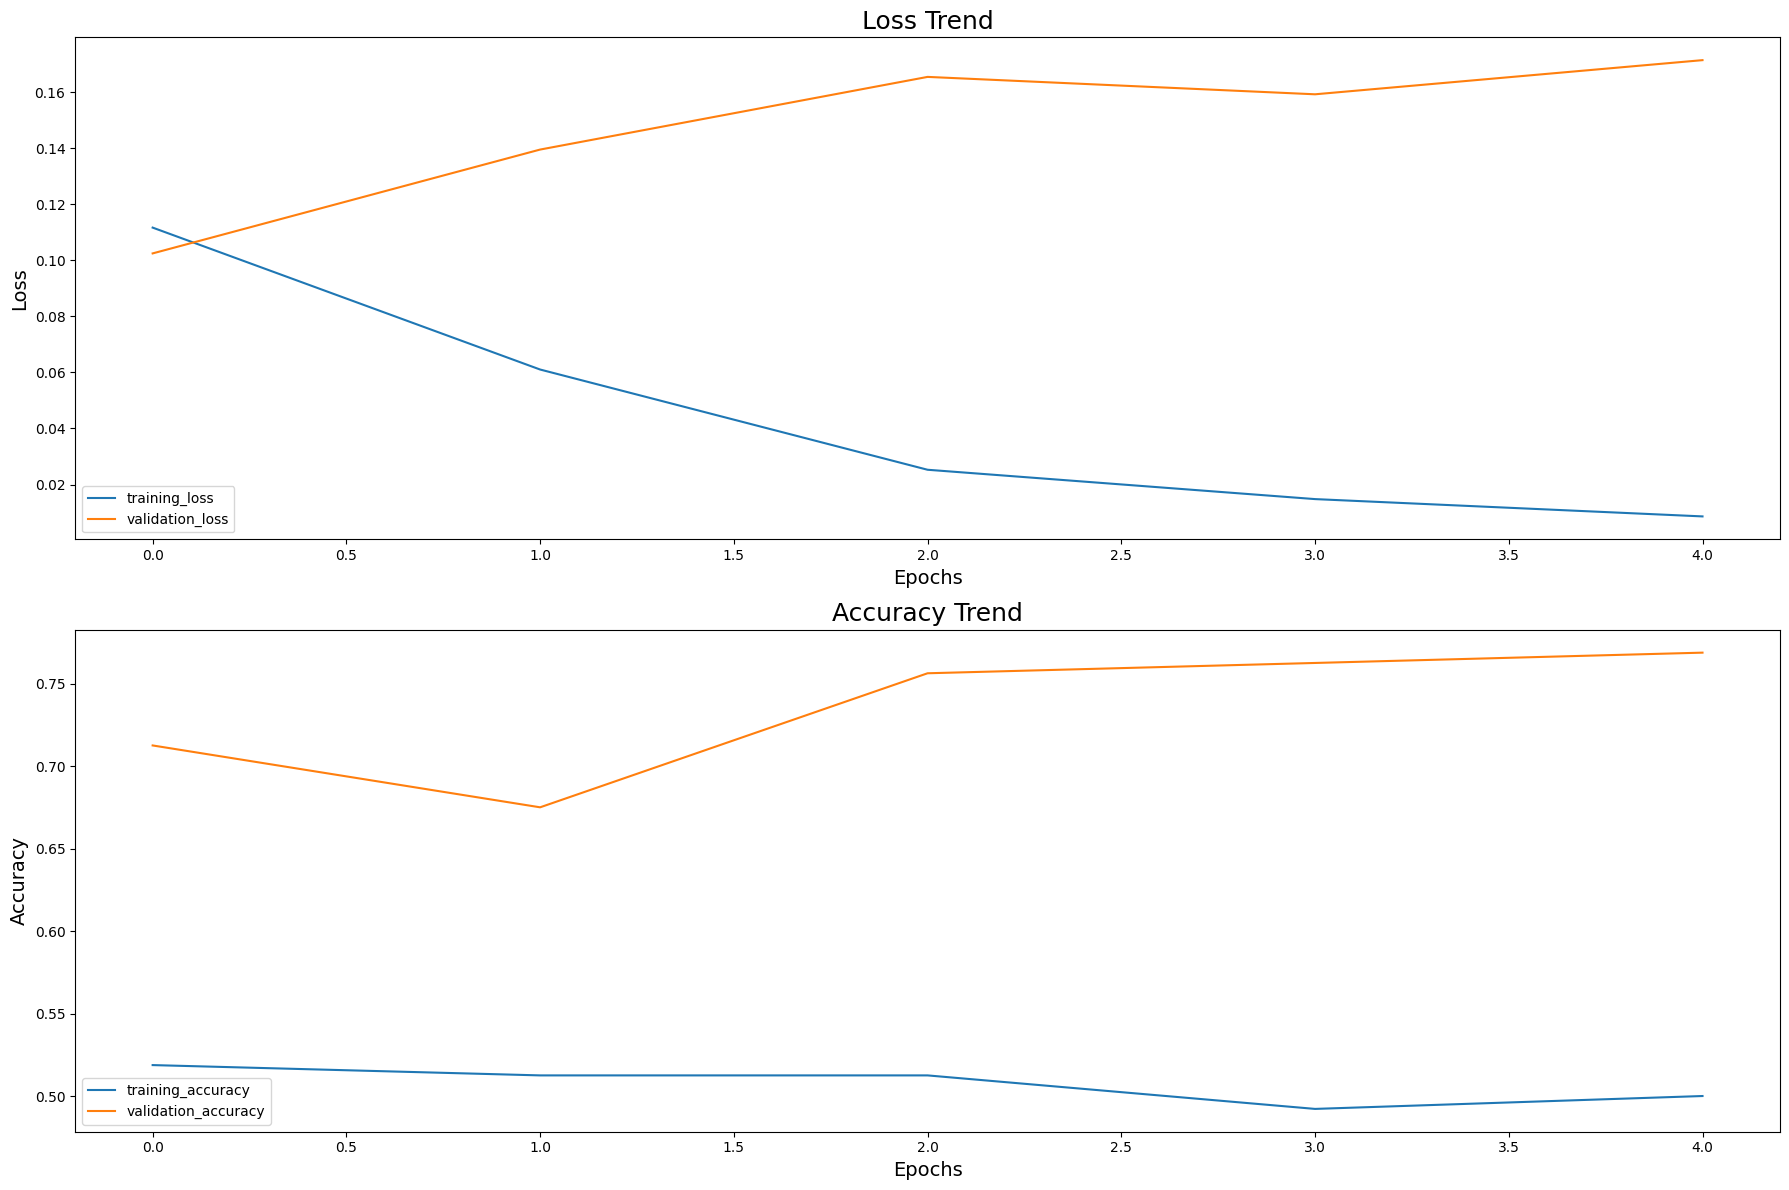

In [48]:
plot_training_scores(scores1)

In [82]:
pt_save_directory = './saved_models/bert_ita'
download_pretrained(SAVED_MODELS[0], pt_save_directory)
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
_, metrics1 = testing_network(saved_model, test_dataloader)
for i in metrics1:
    print(f'{i.upper():>10}: {metrics1[i]:.4f}')

  ACCURACY: 0.7900
 PRECISION: 0.7692
        F1: 0.8108
    RECALL: 0.8571


### UMBERTO

In [59]:
tokenizer = AutoTokenizer.from_pretrained("Musixmatch/umberto-commoncrawl-cased-v1", model_max_length=512)

tokenized_datasets = myCustomDataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['File', 'Engagement', 'Manipulation', 'Visual', 'Text'])
tokenized_datasets = tokenized_datasets.rename_column('Hate Speech', 'labels')
tokenized_datasets.set_format("torch")

print(tokenized_datasets)

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 5

Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-300e02937637fcaa.arrow


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-27d1b7e2c5d74982/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-ec324b15ea62c3e6.arrow


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 640
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 160
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
})


In [51]:
model = AutoModelForSequenceClassification.from_pretrained("Musixmatch/umberto-commoncrawl-cased-v1", num_labels=2).to(device)
pt_save_directory = None #'./saved_models/umberto'
scores2 = training_network(model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Some weights of the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 and

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1/5 | Train loss: 0.13660, Eval loss: 0.12462, Train Acc: 0.54531, Eval Acc: 0.64375
EPOCH: 2/5 | Train loss: 0.10519, Eval loss: 0.10928, Train Acc: 0.49375, Eval Acc: 0.75000
EPOCH: 3/5 | Train loss: 0.06183, Eval loss: 0.12533, Train Acc: 0.49219, Eval Acc: 0.75625
EPOCH: 4/5 | Train loss: 0.04639, Eval loss: 0.12537, Train Acc: 0.49375, Eval Acc: 0.76250
EPOCH: 5/5 | Train loss: 0.04413, Eval loss: 0.17486, Train Acc: 0.47813, Eval Acc: 0.75000


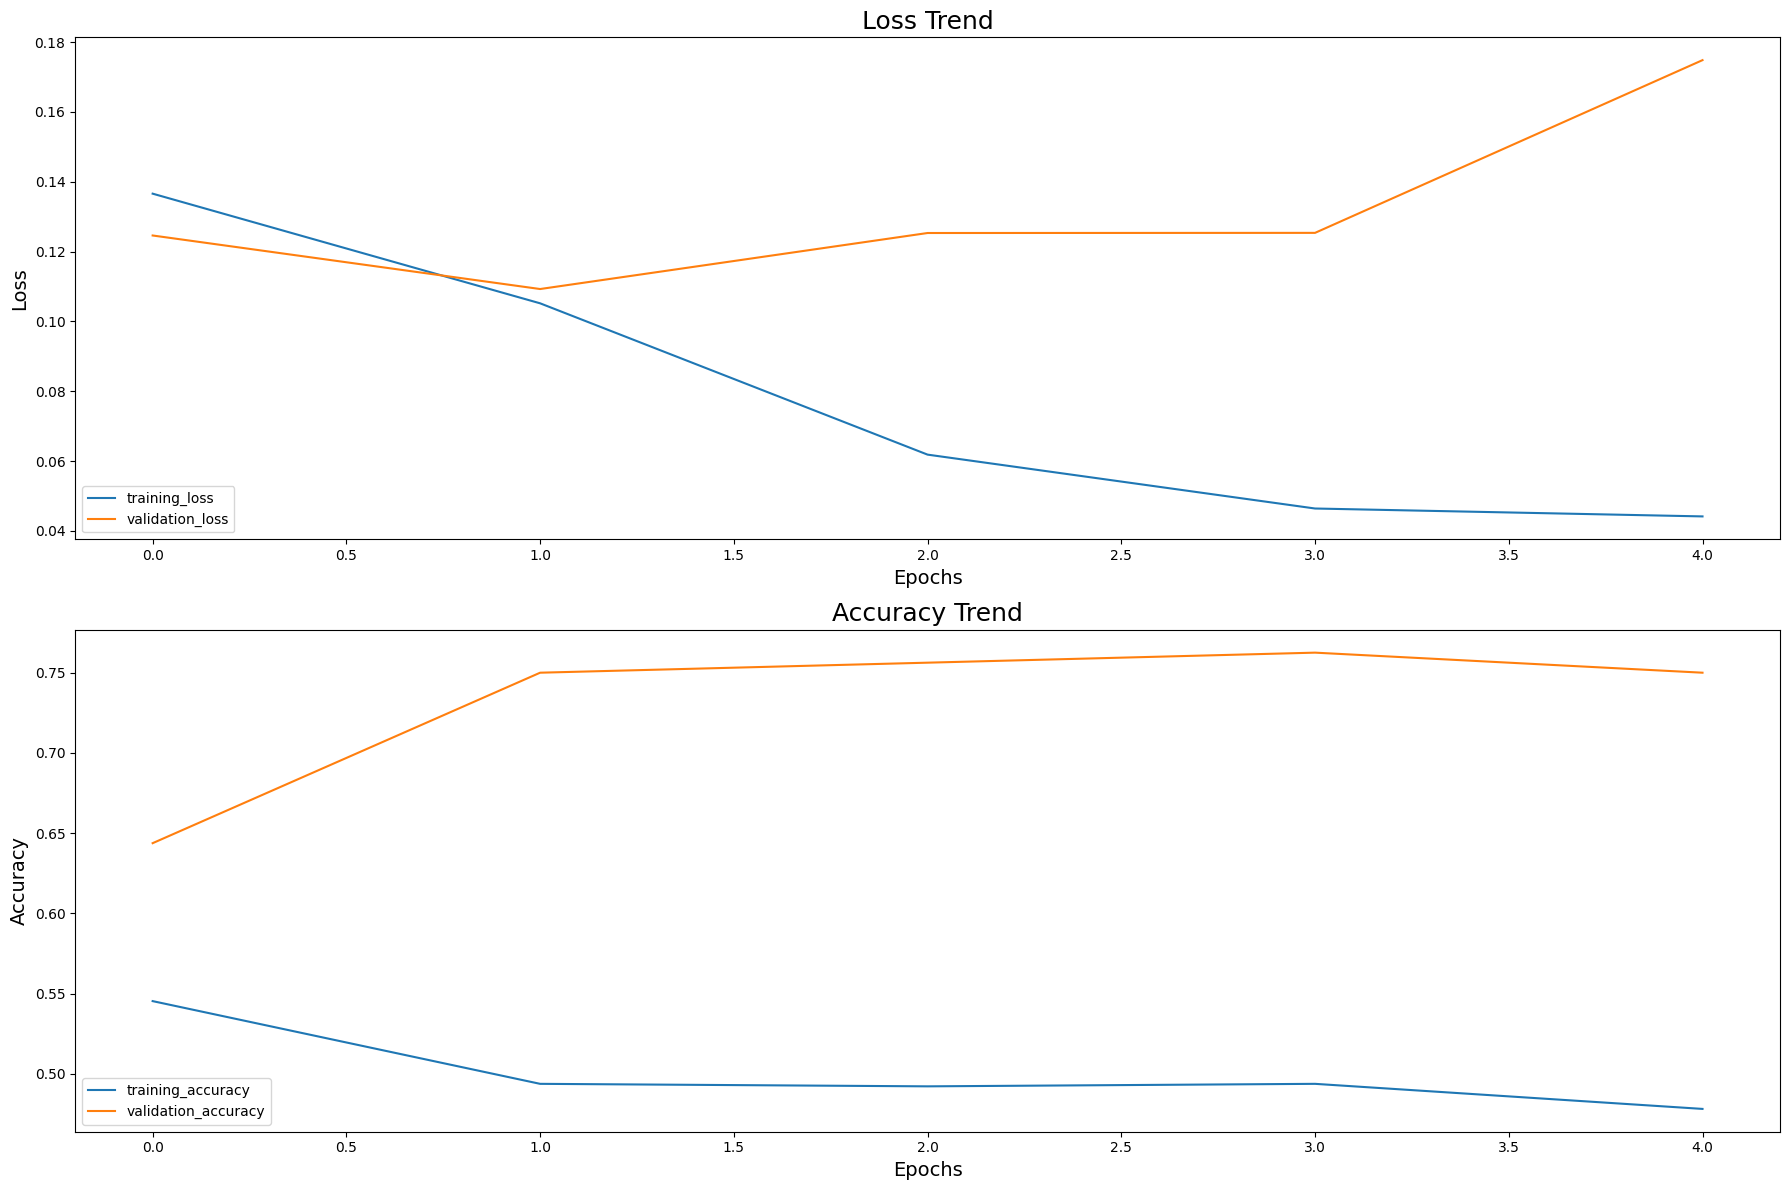

In [52]:
plot_training_scores(scores2)

In [61]:
pt_save_directory = './saved_models/umberto'
download_pretrained(SAVED_MODELS[1], pt_save_directory)
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
_, metrics2 = testing_network(saved_model, test_dataloader)
for i in metrics2:
    print(f'{i.upper():>10}: {metrics2[i]:.4f}')

  ACCURACY: 0.7600
 PRECISION: 0.9130
        F1: 0.7241
    RECALL: 0.6000


### FEEL-IT

In [62]:
tokenizer = AutoTokenizer.from_pretrained("MilaNLProc/feel-it-italian-emotion", model_max_length=512)

tokenized_datasets = myCustomDataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['File', 'Engagement', 'Manipulation', 'Visual', 'Text'])
tokenized_datasets = tokenized_datasets.rename_column('Hate Speech', 'labels')
tokenized_datasets.set_format("torch")

print(tokenized_datasets)

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 5

Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-977e42d9079da669.arrow


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-27d1b7e2c5d74982/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-04d1060a6cbfe40e.arrow


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 640
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 160
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
})


In [55]:
model = AutoModelForSequenceClassification.from_pretrained("MilaNLProc/feel-it-italian-emotion", num_labels=2, ignore_mismatched_sizes=True).to(device)
pt_save_directory = None #'./saved_models/feel_it'
scores3 = training_network(model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at MilaNLProc/feel-it-italian-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1/5 | Train loss: 0.11262, Eval loss: 0.11718, Train Acc: 0.52344, Eval Acc: 0.70625
EPOCH: 2/5 | Train loss: 0.08696, Eval loss: 0.14913, Train Acc: 0.50938, Eval Acc: 0.66250
EPOCH: 3/5 | Train loss: 0.06944, Eval loss: 0.10614, Train Acc: 0.50781, Eval Acc: 0.79375
EPOCH: 4/5 | Train loss: 0.05087, Eval loss: 0.20357, Train Acc: 0.50313, Eval Acc: 0.62500
EPOCH: 5/5 | Train loss: 0.04982, Eval loss: 0.10851, Train Acc: 0.50625, Eval Acc: 0.80000


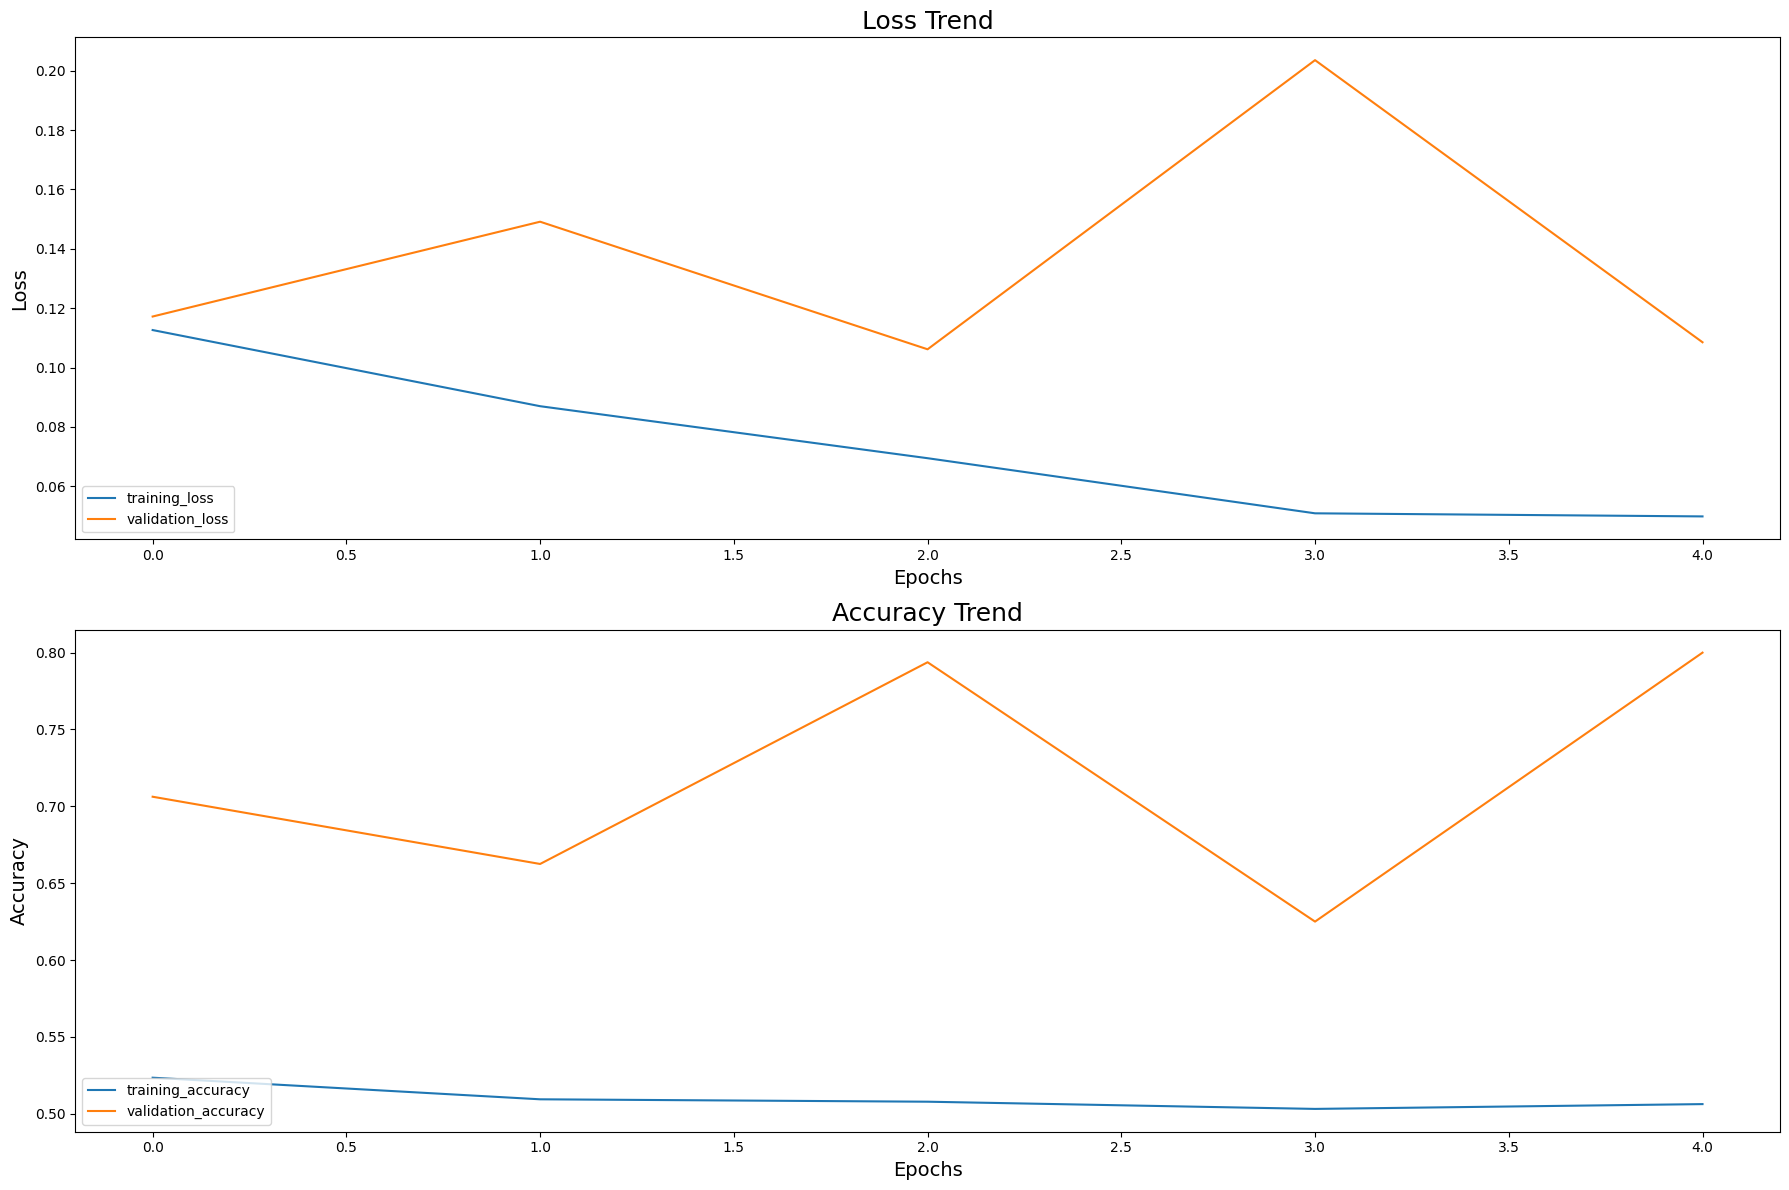

In [56]:
plot_training_scores(scores3)

In [64]:
pt_save_directory = './saved_models/feel_it'
download_pretrained(SAVED_MODELS[2], pt_save_directory)
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
_, metrics3 = testing_network(saved_model, test_dataloader)
for i in metrics3:
    print(f'{i.upper():>10}: {metrics3[i]:.4f}')

  ACCURACY: 0.8200
 PRECISION: 0.8966
        F1: 0.8125
    RECALL: 0.7429


### ROBERTA

In [65]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base", model_max_length=512)

tokenized_datasets = myCustomDataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['File', 'Engagement', 'Manipulation', 'Visual', 'Text'])
tokenized_datasets = tokenized_datasets.rename_column('Hate Speech', 'labels')
tokenized_datasets.set_format("torch")

print(tokenized_datasets)

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 5

Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-52c8086009c93171.arrow


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-27d1b7e2c5d74982/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-092aeeafd7472b9c.arrow


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 640
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 160
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
})


In [59]:
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-xlm-roberta-base", num_labels=2).to(device)
pt_save_directory = None #'./saved_models/roberta'
scores4 = training_network(model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Some weights of the model checkpoint at cardiffnlp/twitter-xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['classifier.den

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1/5 | Train loss: 0.13012, Eval loss: 0.11547, Train Acc: 0.50469, Eval Acc: 0.65625
EPOCH: 2/5 | Train loss: 0.10197, Eval loss: 0.10233, Train Acc: 0.49844, Eval Acc: 0.73125
EPOCH: 3/5 | Train loss: 0.06656, Eval loss: 0.13415, Train Acc: 0.52969, Eval Acc: 0.76250
EPOCH: 4/5 | Train loss: 0.04321, Eval loss: 0.11813, Train Acc: 0.49375, Eval Acc: 0.79375
EPOCH: 5/5 | Train loss: 0.02556, Eval loss: 0.12037, Train Acc: 0.47813, Eval Acc: 0.78125


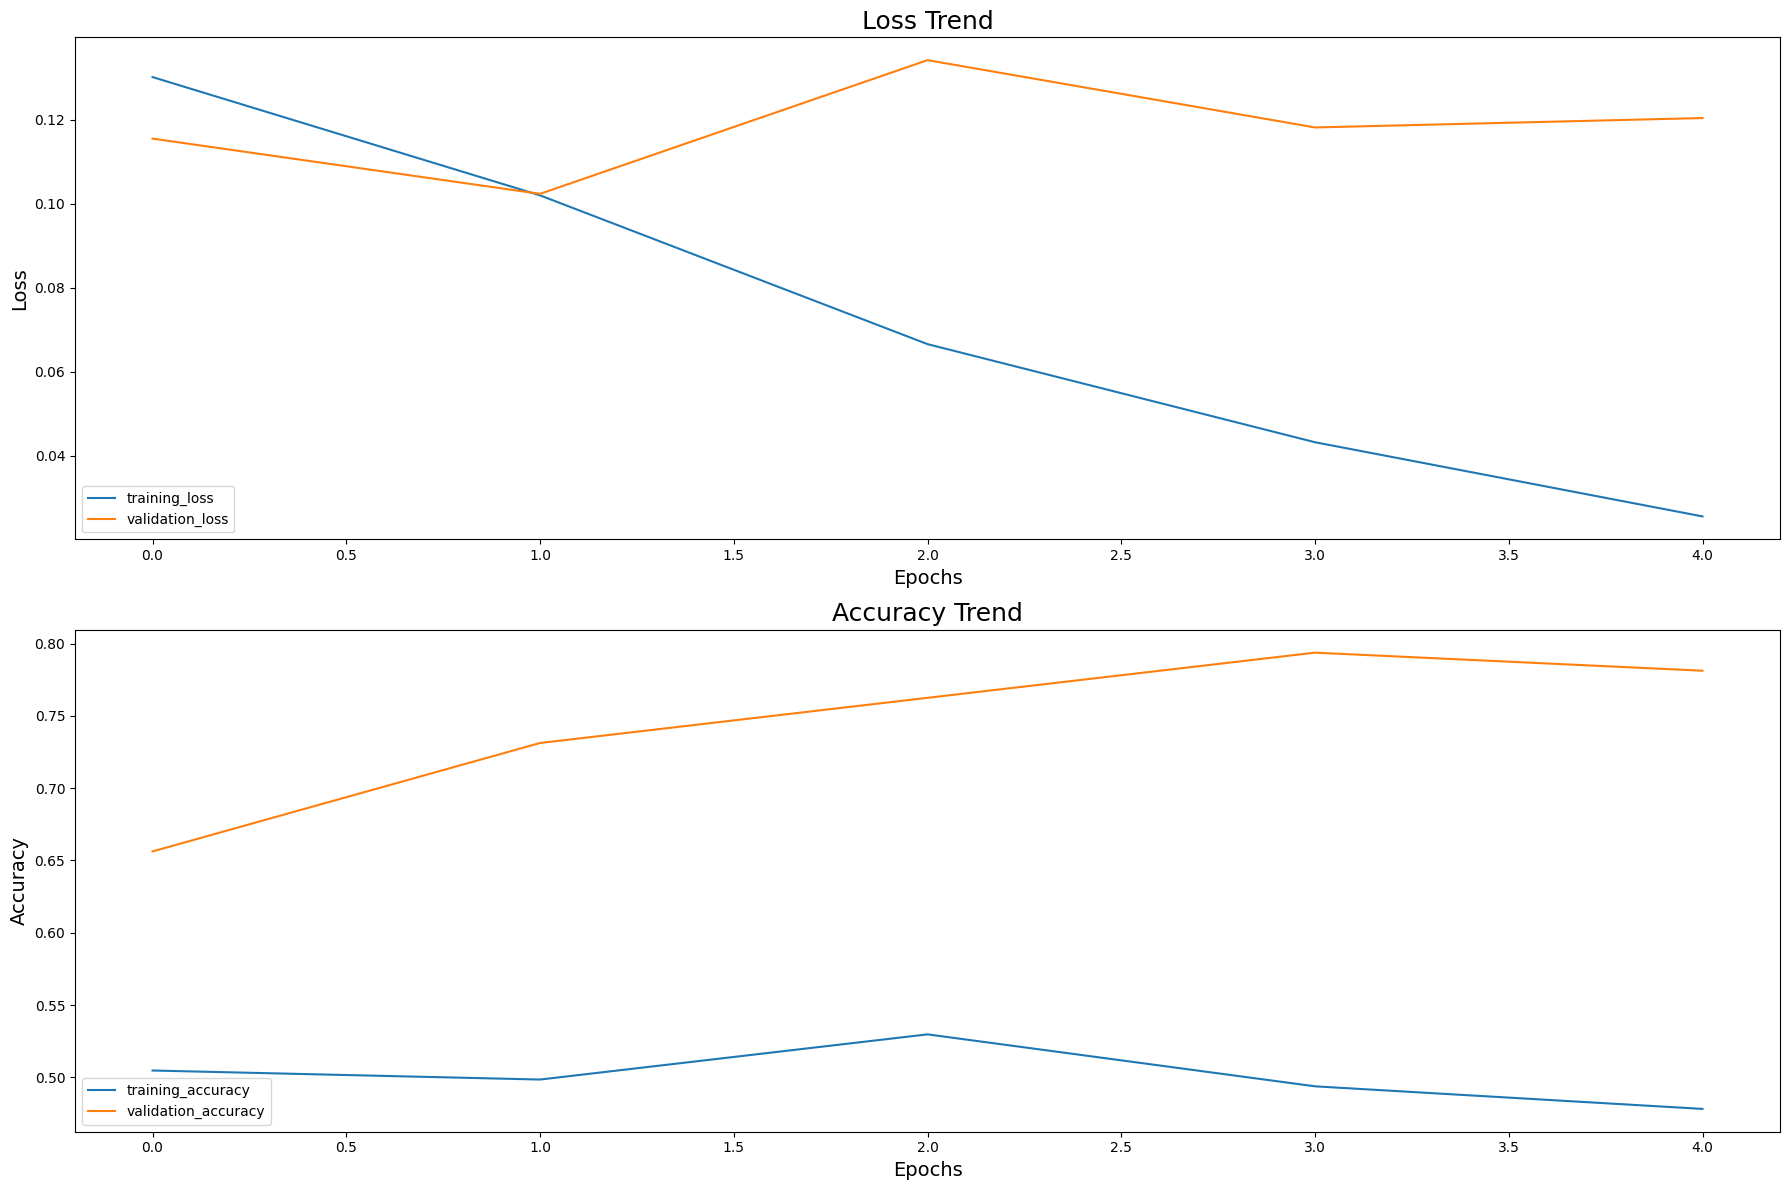

In [60]:
plot_training_scores(scores4)

In [67]:
pt_save_directory = './saved_models/roberta'
download_pretrained(SAVED_MODELS[3], pt_save_directory)
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
_, metrics4 = testing_network(saved_model, test_dataloader)
for i in metrics4:
    print(f'{i.upper():>10}: {metrics3[i]:.4f}')

  ACCURACY: 0.8200
 PRECISION: 0.8966
        F1: 0.8125
    RECALL: 0.7429


### Models comparison

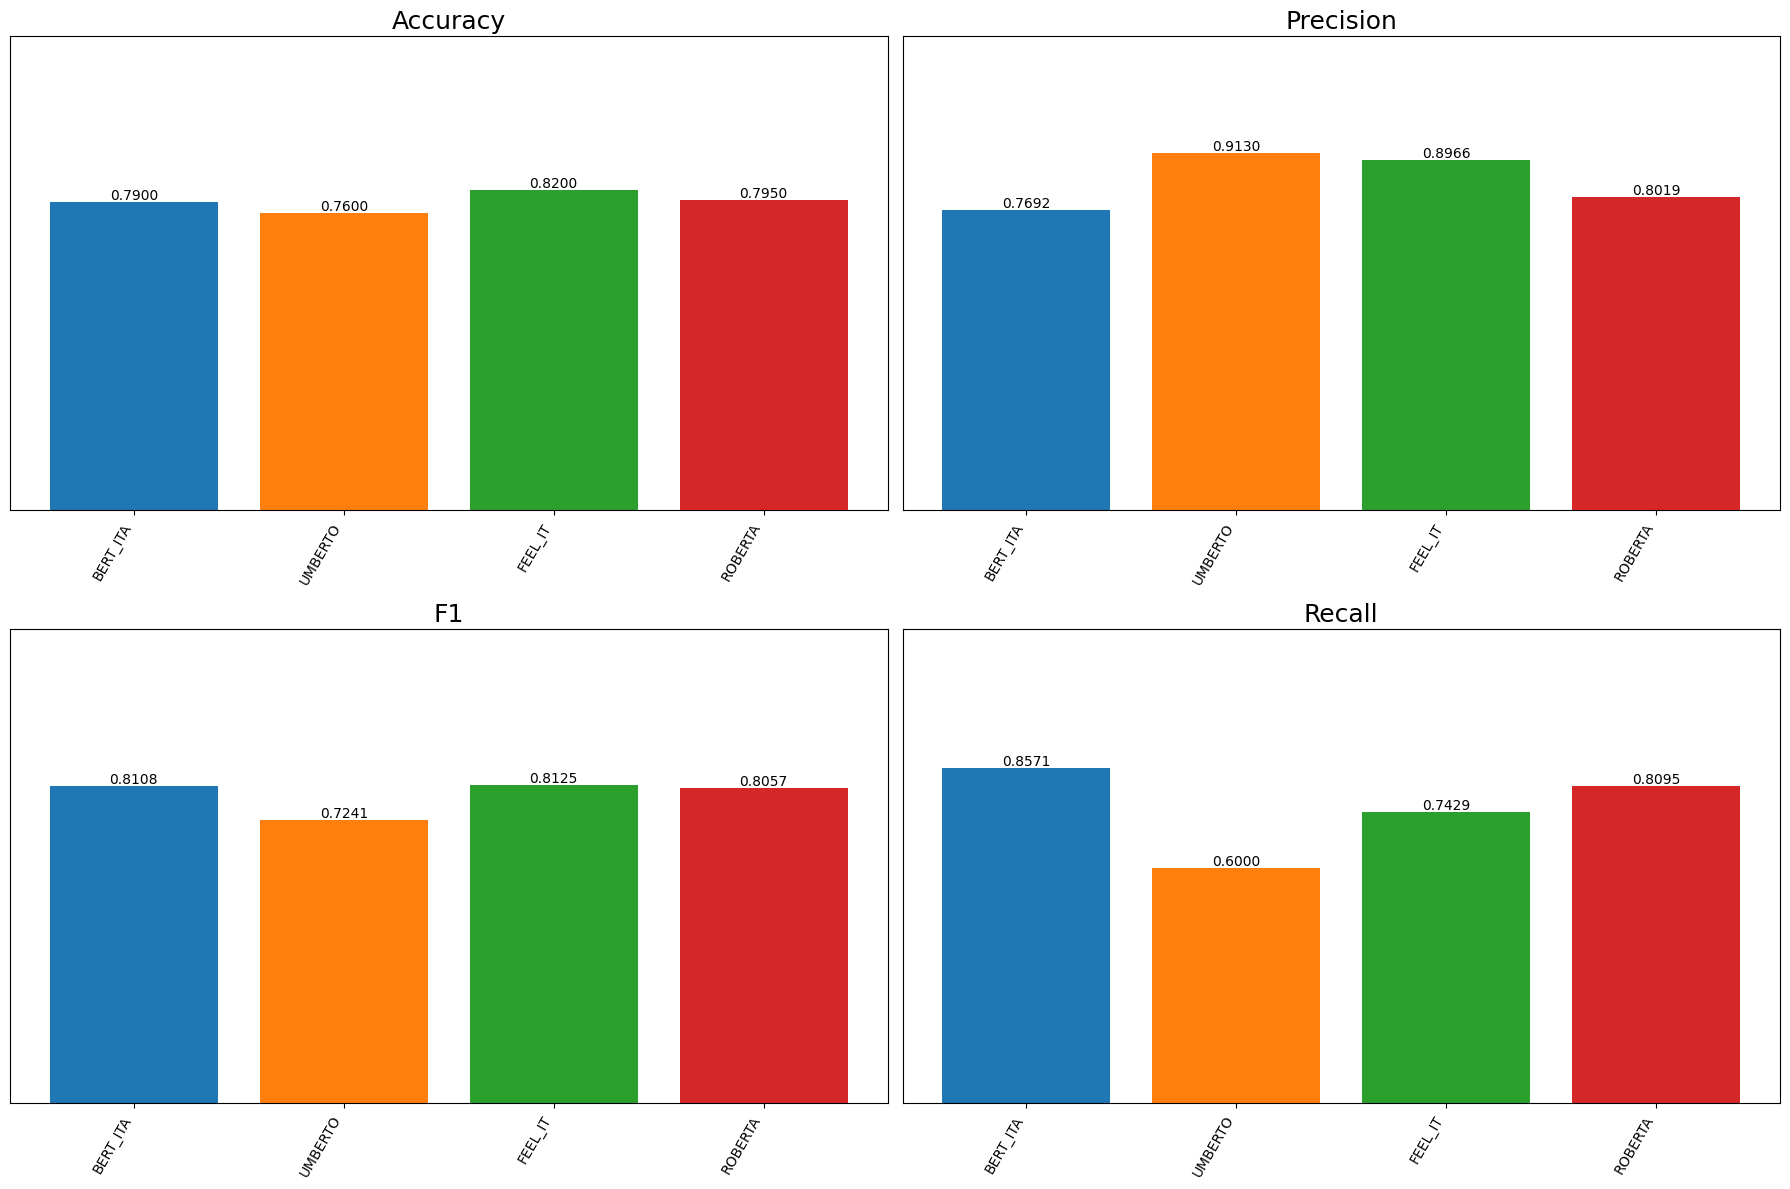

In [68]:
height1 = [metrics1['accuracy'],  metrics2['accuracy'],  metrics3['accuracy'],  metrics4['accuracy']]
height2 = [metrics1['precision'], metrics2['precision'], metrics3['precision'], metrics4['precision']]
height3 = [metrics1['f1'],        metrics2['f1'],        metrics3['f1'],        metrics4['f1']]
height4 = [metrics1['recall'],    metrics2['recall'],    metrics3['recall'],    metrics4['recall']]
labels = ['BERT_ITA', 'UMBERTO', 'FEEL_IT', 'ROBERTA']

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.bar(labels, height=height1, color=colors)
for rect in bars1:
     height = rect.get_height()
     ax1.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
bars2 = ax2.bar(labels, height=height2, color=colors)
for rect in bars2:
     height = rect.get_height()
     ax2.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
bars3 = ax3.bar(labels, height=height3, color=colors)
for rect in bars3:
     height = rect.get_height()
     ax3.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
bars4 = ax4.bar(labels, height=height4, color=colors)
for rect in bars4:
     height = rect.get_height()
     ax4.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])
ax1.set_title('Accuracy', fontsize = 18)
ax2.set_title('Precision', fontsize = 18)
ax3.set_title('F1', fontsize = 18)
ax4.set_title('Recall', fontsize = 18)
ax1.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax2.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax3.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax4.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax1.set_xticklabels(labels, rotation = 60, ha="right")
ax2.set_xticklabels(labels, rotation = 60, ha="right")
ax3.set_xticklabels(labels, rotation = 60, ha="right")
ax4.set_xticklabels(labels, rotation = 60, ha="right")
plt.tight_layout()
plt.show()

In [99]:
print(''.join(['> ' for i in range(40)]))
print(f'\n{"MODEL":<25}{"METRICS MEAN":>18}\n')
print(''.join(['> ' for i in range(40)]))
print(f'{"BERT_ITA:":<25}{np.mean([i for i in metrics1.values()]):>18.3f}')
print(f'{"UMBERTO:":<25}{np.mean([i for i in metrics2.values()]):>18.3f}')
print(f'\033[1m{"FEEL_IT:":<25}\033[0m\033[1m{np.mean([i for i in metrics3.values()]):>18.3f}\033[0m')
print(f'{"ROBERTA:":<25}{np.mean([i for i in metrics4.values()]):>18.3f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

MODEL                          METRICS MEAN

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
BERT_ITA:                             0.807
UMBERTO:                              0.749
FEEL_IT:                              0.818
ROBERTA:                              0.803


## Images model

In [40]:
embeddings_train = pd.read_csv(BASE_PATHS[1] + FILENAMES[4], header=None)
embeddings_train['Train Embeddings'] = [np.array(i.split()).astype(np.float32) for i in embeddings_train.loc[:][1]]
embeddings_train['Labels'] = data['Hate Speech']
embeddings_train = embeddings_train[['Train Embeddings','Labels']]
embeddings_train.head()

,Train Embeddings,Labels
0,"[0.03371752, 0.71383077, 0.1622142, 0.15153012...",1
1,"[0.017445266, 0.01675424, 0.06025219, 0.088076...",0
2,"[0.2331691, 2.1796272, 0.0, 0.004503002, 1.169...",1
3,"[0.09365508, 1.8714182, 0.5247863, 0.039612748...",1
4,"[0.12720379, 1.260958, 0.1069836, 0.27789292, ...",0


In [41]:
embeddings_test = pd.read_csv(BASE_PATHS[4] + FILENAMES[10], header=None)
embeddings_test['Test Embeddings'] = [np.array(i.split()).astype(np.float32) for i in embeddings_test.loc[:][1]]
goldData = pd.read_csv(BASE_PATHS[4] + FILENAMES[14])
embeddings_test['Labels'] = goldData['Hate Speech']
embeddings_test = embeddings_test[['Test Embeddings', 'Labels']]
embeddings_test.head()

,Test Embeddings,Labels
0,"[0.27691776, 0.952373, 0.06241767, 0.58647937,...",1
1,"[0.07759489, 1.8289204, 1.7770578, 0.07402565,...",0
2,"[0.28806925, 1.3223957, 0.07227258, 0.24837093...",1
3,"[0.3849284, 0.94429594, 0.8429149, 0.53647035,...",0
4,"[0.06668279, 0.85113406, 0.40766233, 0.3558357...",1


In [42]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

class MySimpleNetworkClassifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 1024)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(1024, 512)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(512, 128)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(128, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.tanh(self.output(x))
        return x

In [43]:
def fit_NN(net, X_train_net, X_eval_net, y_train_net, y_eval_net, n_epochs, batch=100, optimizer=None, verbose=(False,1)):

    torch.manual_seed(42)
    loss_fn = nn.BCEWithLogitsLoss()
    if optimizer is None:
        optimizer = torch.optim.SGD(params=net.parameters(), lr=.1)
    scores = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    num_training_steps = n_epochs * len(X_train_net)
    num_validation_steps = n_epochs * len(X_eval_net)

    for epoch in range(n_epochs):
        ### Training
        net.train()
        trainLosses = 0
        evalLosses = 0
        trainPred = []
        evalPred = []
        if batch is None:
            batch = len(X_train_net)
        for i in range(0, len(X_train_net), batch):
            X_train = X_train_net[i:i+batch]
            y_train = y_train_net[i:i+batch]
            # 1. Forward pass (model outputs raw logits)
            y_logits = net(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
            y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
            # 2. Calculate loss
            loss = loss_fn(y_logits, y_train) # Using nn.BCEWithLogitsLoss works with raw logits
            trainLosses += loss
            trainPred += y_pred.detach().cpu().numpy().tolist()
            # 3. Optimizer zero grad
            optimizer.zero_grad()
            # 4. Loss backwards
            loss.backward()
            # 5. Optimizer step
            optimizer.step()

        ### Evaluation
        with torch.inference_mode():
            net.eval()
            if batch is None:
                batch = len(X_eval_net)
            # 1. Forward pass
            for i in range(0, len(X_eval_net), batch):
                X_eval = X_eval_net[i:i+batch]
                y_eval = y_eval_net[i:i+batch]
                test_logits = net(X_eval).squeeze()
                test_pred = torch.round(torch.sigmoid(test_logits))
                # 2. Caculate loss
                test_loss = loss_fn(test_logits, y_eval)
                evalLosses += test_loss
                evalPred += test_pred.detach().cpu().numpy().tolist()

        avgTrainLoss = trainLosses / num_training_steps
        avgValLoss = evalLosses / num_validation_steps
        scores['train_loss'].append(avgTrainLoss.detach().cpu().numpy())
        scores['val_loss'].append(avgValLoss.detach().cpu().numpy())
        acc_train = accuracy_fn(y_true=y_train_net, y_pred=torch.tensor(trainPred).to(device))
        acc_eval = accuracy_fn(y_true=y_eval_net, y_pred=torch.tensor(evalPred).to(device))
        scores['train_acc'].append(acc_train)
        scores['val_acc'].append(acc_eval)

        # Print out what's happening every 100 epochs
        if epoch % verbose[1] == 0 and verbose[0] == True:
            print(f"Epoch: {epoch} | Train Loss: {avgTrainLoss*10000:.5f}, Train Accuracy: {acc_train:.2f}% | Eval loss: {avgValLoss*10000:.5f}, Eval acc: {acc_eval:.2f}%")
    
    return net, scores

In [44]:
def predict_NN(net, X_test_net, y_test_net):
    torch.manual_seed(42)
    net.eval()
    with torch.no_grad():
        test_logits = net(X_test_net).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_acc = accuracy_fn(y_true=y_test_net, y_pred=test_pred)
    return test_acc, test_pred

In [45]:
# Preparing the data
n_features = len(embeddings_train['Train Embeddings'][0])
X_train_net = np.array([i for i in embeddings_train['Train Embeddings'].values])
y_train_net = embeddings_train['Labels'].to_numpy()
X_test_net = np.array([i for i in embeddings_test['Test Embeddings'].values])
y_test_net = embeddings_test['Labels'].to_numpy()
split = int(len(X_train_net) * .8)
X_eval_net = X_train_net[split:]
y_eval_net = y_train_net[split:]
X_train_net = X_train_net[:split]
y_train_net = y_train_net[:split]

X_train_net = torch.tensor(data = X_train_net.reshape(len(X_train_net), n_features), dtype=torch.float32).to(device)
X_eval_net = torch.tensor(data = X_eval_net.reshape(len(X_eval_net), n_features), dtype=torch.float32).to(device)
X_test_net = torch.tensor(data = X_test_net.reshape(len(X_test_net), n_features), dtype=torch.float32).to(device)
y_train_net = torch.tensor(data = y_train_net, dtype=torch.float32).to(device)
y_eval_net = torch.tensor(data = y_eval_net, dtype=torch.float32).to(device)
y_test_net = torch.tensor(data = y_test_net, dtype=torch.float32).to(device)

print("Training Shape: ", X_train_net.shape, y_train_net.shape)
print("Evaluation Shape: ", X_eval_net.shape, y_eval_net.shape)
print("Testing Shape: ", X_test_net.shape, y_test_net.shape) 

Training Shape:  torch.Size([640, 2048]) torch.Size([640])
Evaluation Shape:  torch.Size([160, 2048]) torch.Size([160])
Testing Shape:  torch.Size([200, 2048]) torch.Size([200])


In [46]:
net = MySimpleNetworkClassifier(n_features).to(device)
model, metrics = fit_NN(net, X_train_net, X_eval_net, y_train_net, y_eval_net, n_epochs=6, batch=10, verbose=(True,1))
accuracy_nn, pred = predict_NN(model, X_test_net, y_test_net)

Epoch: 0 | Train Loss: 115.85227, Train Accuracy: 49.06% | Eval loss: 114.73346, Eval acc: 55.00%
Epoch: 1 | Train Loss: 115.40221, Train Accuracy: 52.97% | Eval loss: 113.92260, Eval acc: 55.00%
Epoch: 2 | Train Loss: 114.79403, Train Accuracy: 55.62% | Eval loss: 113.17427, Eval acc: 56.25%
Epoch: 3 | Train Loss: 113.71318, Train Accuracy: 57.03% | Eval loss: 111.98674, Eval acc: 55.62%
Epoch: 4 | Train Loss: 112.14421, Train Accuracy: 59.22% | Eval loss: 110.06335, Eval acc: 58.13%
Epoch: 5 | Train Loss: 110.23492, Train Accuracy: 61.88% | Eval loss: 108.52444, Eval acc: 61.25%


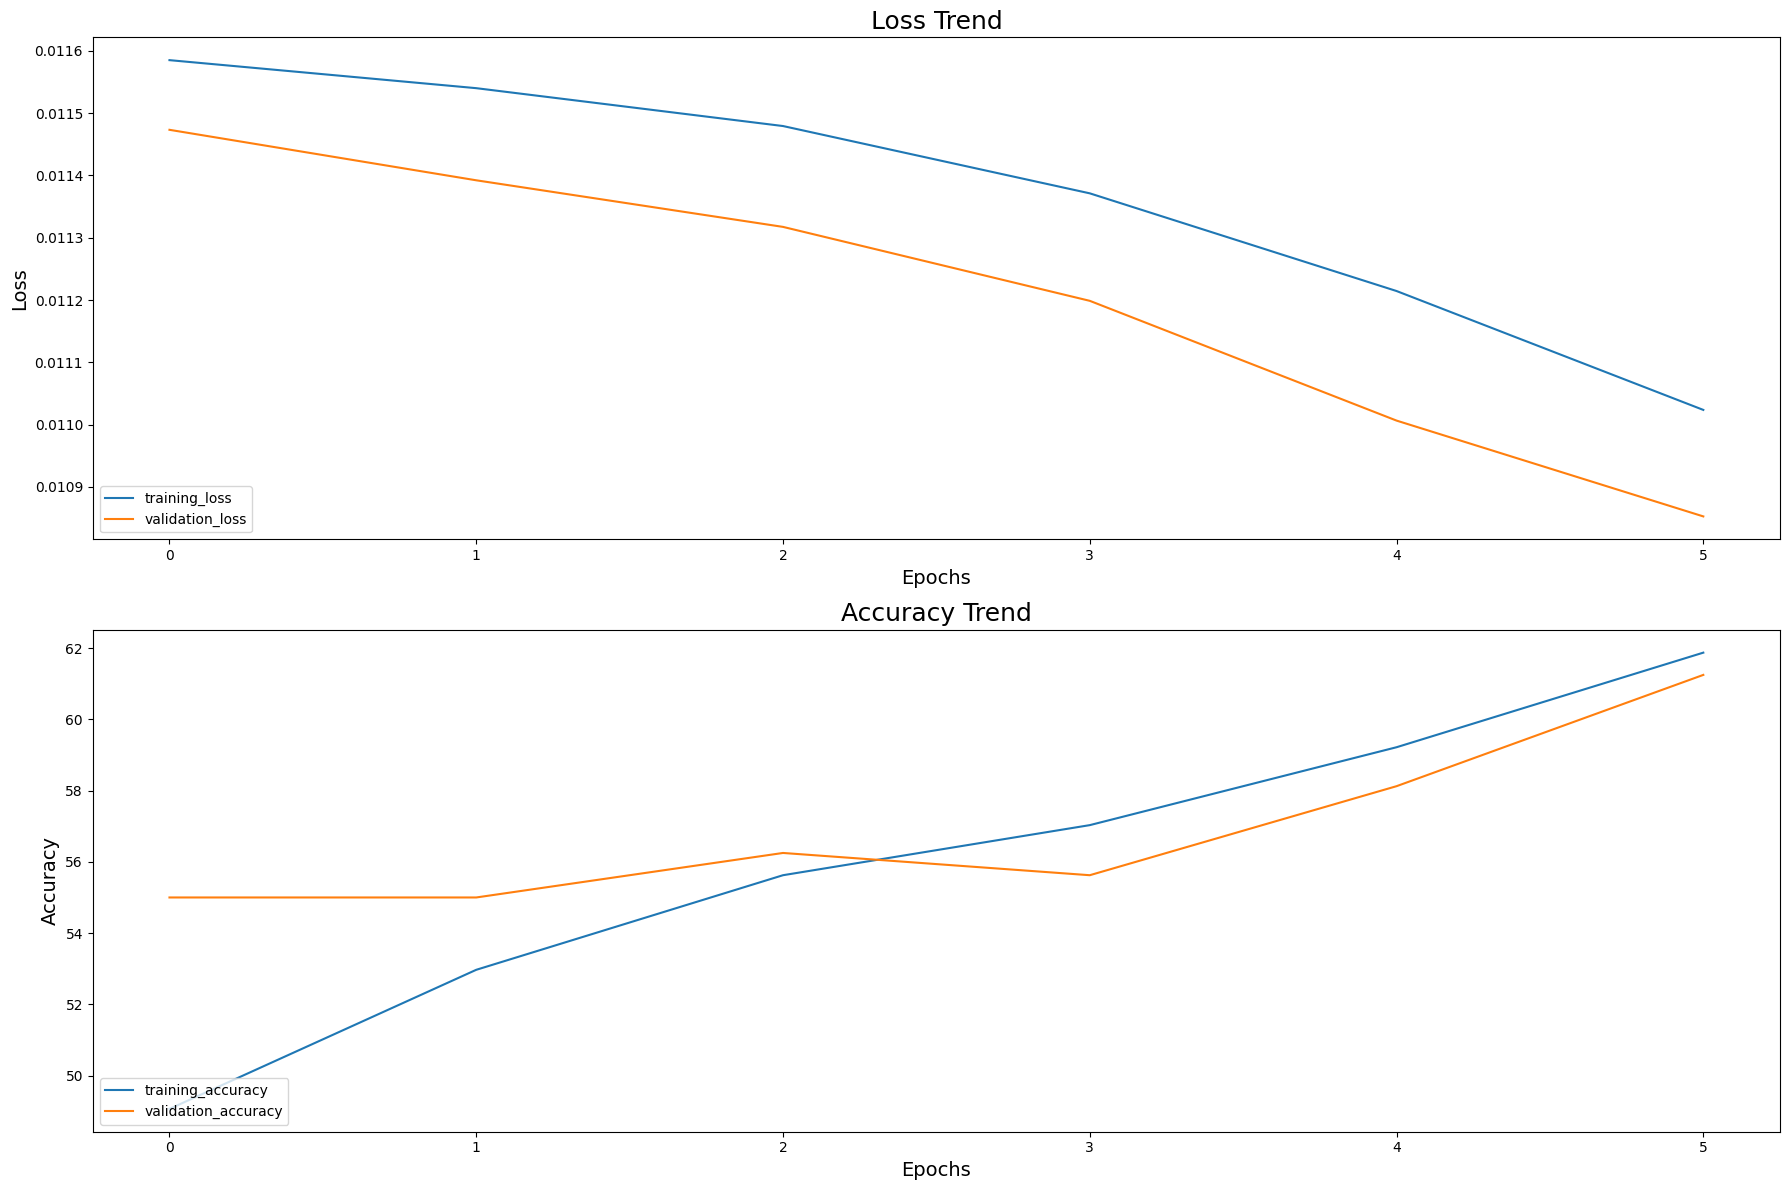

In [47]:
plot_training_scores(metrics)

In [48]:
print(f'\nTest Accuracy:\033[32m \033[01m {accuracy_nn:.2f}% \033[30m \033[0m')
print(classification_report(y_test_net.detach().cpu().numpy(), pred.detach().cpu().numpy(), target_names=['no_hate', 'hate']))


Test Accuracy:  53.50%  
              precision    recall  f1-score   support

     no_hate       0.51      0.83      0.63        95
        hate       0.64      0.27      0.38       105

    accuracy                           0.54       200
   macro avg       0.57      0.55      0.50       200
weighted avg       0.57      0.54      0.50       200



## Metadata model

In [49]:
### TRAINING SET FEATURES SELECTION
metadata_train = data[['Engagement', 'Manipulation', 'Hate Score', 'Nr Words', 'Nr Tokens', 'Hate Speech']]
metadata_train.head()

,Engagement,Manipulation,Hate Score,Nr Words,Nr Tokens,Hate Speech
0,381,0,NaN,15,8,1
1,142,1,NaN,14,7,0
2,3598,1,7.0,17,10,1
3,165,1,-37.0,9,3,1
4,44,0,NaN,26,21,0


In [50]:
### TEST SET FEATURES EXTRACTION AND SELECTION
metadata_test = pd.read_csv(BASE_PATHS[4] + FILENAMES[14])

# Tokens
metadata_test['Tokens'] = metadata_test['Text'].apply(lambda x:' '.join(my_preprocessing(x)))

# Hate score
visuals = metadata_test['Visual']
people = []
for i in visuals:
    s = i.split(',')
    s = [j.strip() for j in s if j != ' ' and j != '']
    for e in s:
        if (e is not '0' and e.title() not in people):
            people.append(e.title())
df_scores = pd.DataFrame(index=[p.title() for p in people], columns=['Hate Meme','Not Hate Meme','Hate Score'])
for p in people:
    all_by_person = metadata_test[metadata_test['Visual'].str.contains(p, case=False)]
    df_scores.loc[p, 'Hate Meme'] = 0-len(all_by_person[metadata_test['Hate Speech'] == 1])
    df_scores.loc[p, 'Not Hate Meme'] = len(all_by_person[metadata_test['Hate Speech'] == 0])
    df_scores.loc[p, 'Hate Score'] = len(all_by_person[metadata_test['Hate Speech'] == 0]) - len(all_by_person[metadata_test['Hate Speech'] == 1])
metadata_test['Hate Score'] = metadata_test['Visual'].apply(lambda x:get_hate_score(x, df_scores.sort_values('Hate Score')))

# Nr of words
metadata_test['Nr Words'] = metadata_test['Text'].apply(lambda x:len(str(x).split()))

# Nr of words
metadata_test['Nr Tokens'] = metadata_test['Tokens'].apply(lambda x:len(str(x).split()))

metadata_test = metadata_test[['Engagement', 'Manipulation', 'Hate Score', 'Nr Words', 'Nr Tokens', 'Hate Speech']]
metadata_test.head()

,Engagement,Manipulation,Hate Score,Nr Words,Nr Tokens,Hate Speech
0,41,0,NaN,5,4,1
1,7,1,-22.0,8,4,0
2,22,0,0.0,12,5,1
3,137,1,1.0,17,10,0
4,2667,0,-2.0,6,3,1


In [51]:
### DATA NORMALIZATION
scaler = MinMaxScaler()

metadata_train['Engagement'] = scaler.fit_transform(metadata_train['Engagement'].values.reshape(-1, 1))
metadata_train['Nr Words'] = scaler.fit_transform(metadata_train['Nr Words'].values.reshape(-1, 1))
metadata_train['Nr Tokens'] = scaler.fit_transform(metadata_train['Nr Words'].values.reshape(-1, 1))
metadata_train['Hate Score'] = metadata_train['Hate Score'].fillna(0)
metadata_train['Hate Score'] = scaler.fit_transform(metadata_train['Hate Score'].values.reshape(-1, 1))

metadata_test['Engagement'] = scaler.fit_transform(metadata_test['Engagement'].values.reshape(-1, 1))
metadata_test['Nr Words'] = scaler.fit_transform(metadata_test['Nr Words'].values.reshape(-1, 1))
metadata_test['Nr Tokens'] = scaler.fit_transform(metadata_test['Nr Words'].values.reshape(-1, 1))
metadata_test['Hate Score'] = metadata_test['Hate Score'].fillna(0)
metadata_test['Hate Score'] = scaler.fit_transform(metadata_test['Hate Score'].values.reshape(-1, 1))
metadata_test.head()

,Engagement,Manipulation,Hate Score,Nr Words,Nr Tokens,Hate Speech
0,0.001491,0,0.553191,0.042553,0.042553,1
1,0.000224,1,0.085106,0.074468,0.074468,0
2,0.000783,0,0.553191,0.117021,0.117021,1
3,0.005069,1,0.574468,0.170213,0.170213,0
4,0.099370,0,0.510638,0.053191,0.053191,1


In [52]:
### DATA SPLITTING
n_features = 5
X_train_net = metadata_train[['Engagement', 'Manipulation', 'Hate Score', 'Nr Words', 'Nr Tokens']].to_numpy()
y_train_net = metadata_train['Hate Speech'].to_numpy()
X_test_net = metadata_test[['Engagement', 'Manipulation', 'Hate Score', 'Nr Words', 'Nr Tokens']].to_numpy()
y_test_net = metadata_test['Hate Speech'].to_numpy()
split = int(len(X_train_net) * .8)
X_eval_net = X_train_net[split:]
y_eval_net = y_train_net[split:]
X_train_net = X_train_net[:split]
y_train_net = y_train_net[:split]

X_train_net = torch.tensor(data = X_train_net.reshape(len(X_train_net), n_features), dtype=torch.float32).to(device)
X_eval_net = torch.tensor(data = X_eval_net.reshape(len(X_eval_net), n_features), dtype=torch.float32).to(device)
X_test_net = torch.tensor(data = X_test_net.reshape(len(X_test_net), n_features), dtype=torch.float32).to(device)
y_train_net = torch.tensor(data = y_train_net, dtype=torch.float32).to(device)
y_eval_net = torch.tensor(data = y_eval_net, dtype=torch.float32).to(device)
y_test_net = torch.tensor(data = y_test_net, dtype=torch.float32).to(device)

print("Training Shape: ", X_train_net.shape, y_train_net.shape)
print("Evaluation Shape: ", X_eval_net.shape, y_eval_net.shape)
print("Testing Shape: ", X_test_net.shape, y_test_net.shape) 

Training Shape:  torch.Size([640, 5]) torch.Size([640])
Evaluation Shape:  torch.Size([160, 5]) torch.Size([160])
Testing Shape:  torch.Size([200, 5]) torch.Size([200])


In [53]:
net = MySimpleNetworkClassifier(n_features).to(device)
model, metrics = fit_NN(net, X_train_net, X_eval_net, y_train_net, y_eval_net, n_epochs=100, batch=20, verbose=(True,10))
accuracy_nn, pred = predict_NN(model, X_test_net, y_test_net)

Epoch: 0 | Train Loss: 3.46331, Train Accuracy: 50.94% | Eval loss: 3.44343, Eval acc: 62.50%
Epoch: 10 | Train Loss: 3.40071, Train Accuracy: 55.31% | Eval loss: 3.36186, Eval acc: 55.00%
Epoch: 20 | Train Loss: 3.38191, Train Accuracy: 56.56% | Eval loss: 3.31318, Eval acc: 56.88%
Epoch: 30 | Train Loss: 3.37091, Train Accuracy: 57.03% | Eval loss: 3.30206, Eval acc: 55.62%
Epoch: 40 | Train Loss: 3.36418, Train Accuracy: 56.25% | Eval loss: 3.30274, Eval acc: 56.25%
Epoch: 50 | Train Loss: 3.35919, Train Accuracy: 56.72% | Eval loss: 3.30756, Eval acc: 54.37%
Epoch: 60 | Train Loss: 3.35565, Train Accuracy: 56.72% | Eval loss: 3.31269, Eval acc: 55.00%
Epoch: 70 | Train Loss: 3.35244, Train Accuracy: 58.44% | Eval loss: 3.31660, Eval acc: 55.62%
Epoch: 80 | Train Loss: 3.34938, Train Accuracy: 58.75% | Eval loss: 3.31826, Eval acc: 54.37%
Epoch: 90 | Train Loss: 3.34728, Train Accuracy: 59.53% | Eval loss: 3.32001, Eval acc: 54.37%


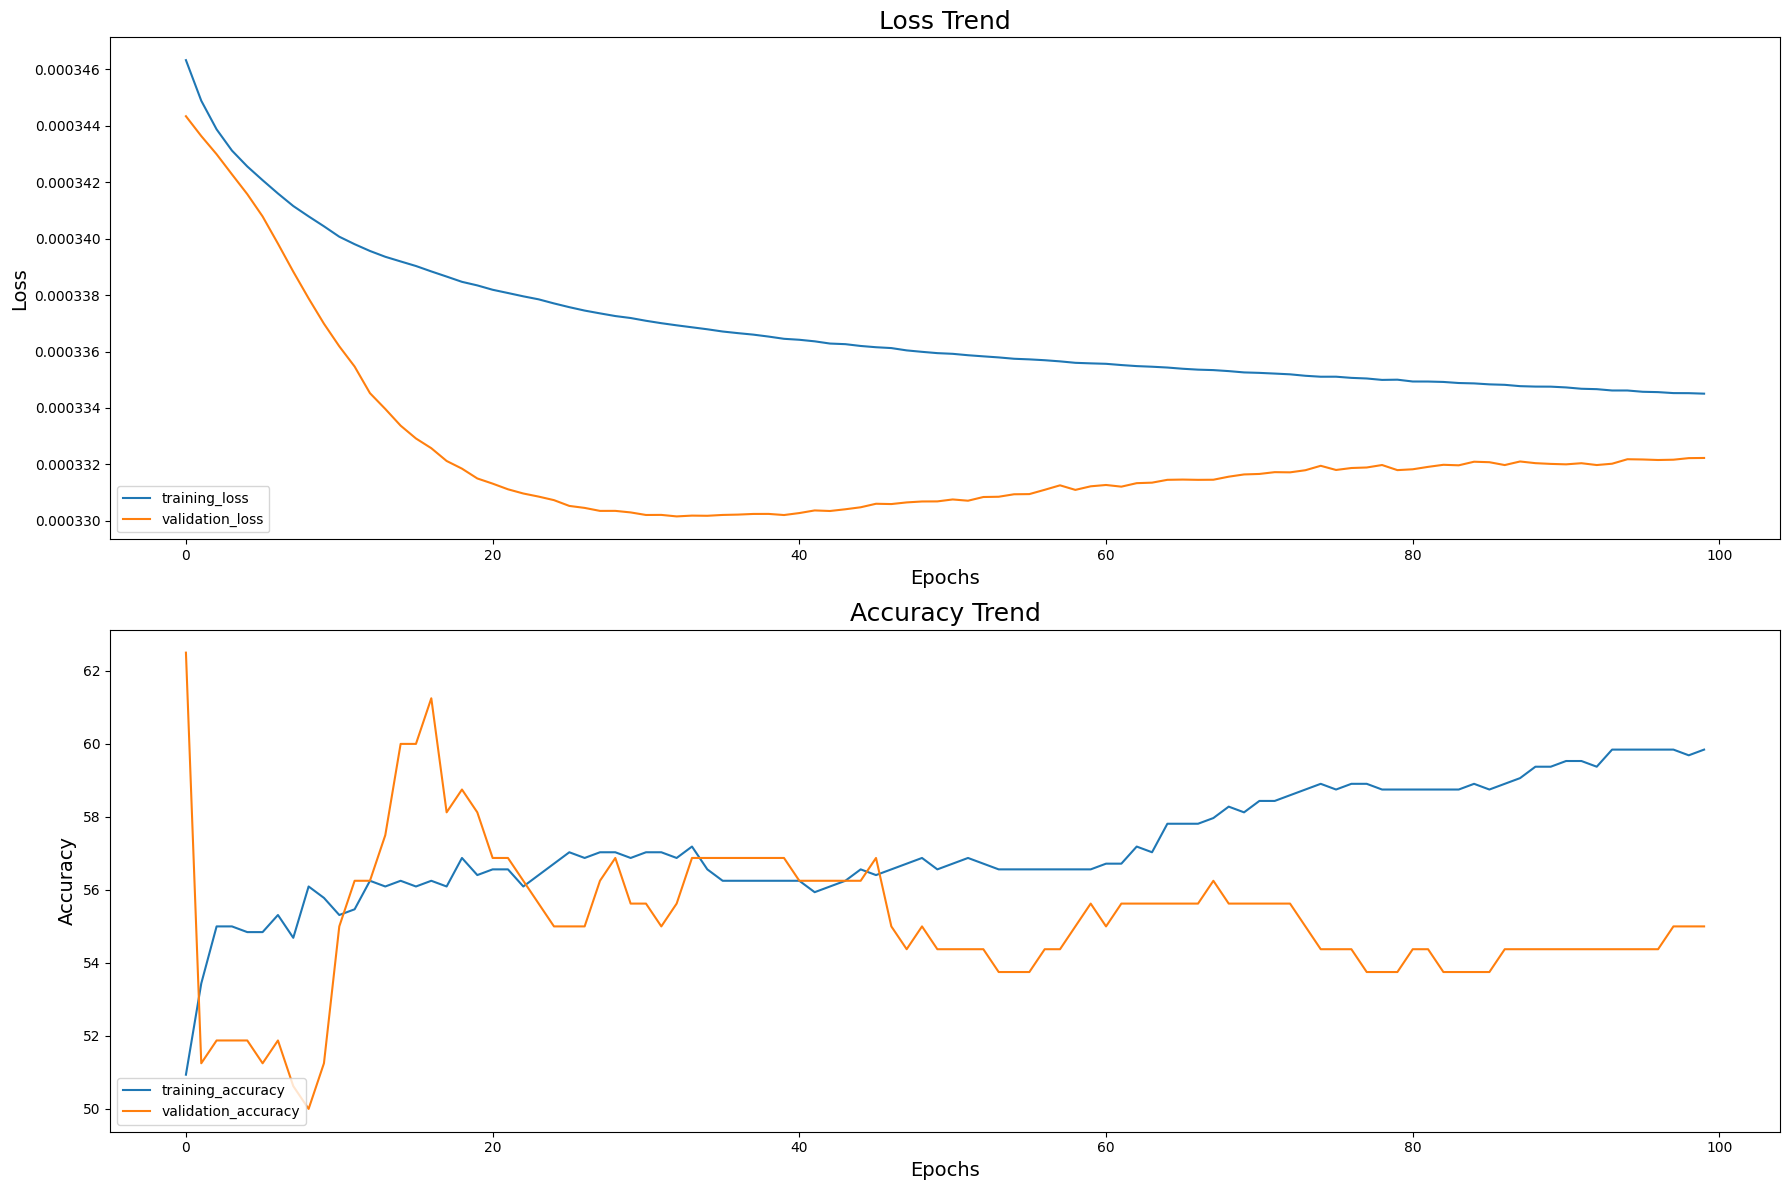

In [54]:
plot_training_scores(metrics)

In [55]:
print(f'\nTest Accuracy:\033[32m \033[01m {accuracy_nn:.2f}% \033[30m \033[0m')
print(classification_report(y_test_net.detach().cpu().numpy(), pred.detach().cpu().numpy(), target_names=['no_hate', 'hate']))


Test Accuracy:  61.50%  
              precision    recall  f1-score   support

     no_hate       0.62      0.47      0.54        95
        hate       0.61      0.74      0.67       105

    accuracy                           0.61       200
   macro avg       0.62      0.61      0.60       200
weighted avg       0.62      0.61      0.61       200



# EXPERIMENTAL PLAYGROUND

---

## 1\) Multimodal classification

In [108]:
def get_majority_vote(list_pred):
    major_pred = []
    for i in range(len(list_pred[0])):
        col = np.array(list_pred)
        major_pred.append(np.bincount(col[:,i]).argmax())
    return major_pred

In [65]:
### GETTING PREDICTIONS FROM TEXTUAL FEATURES
pt_save_directory = './saved_models/feel_it'
download_pretrained(SAVED_MODELS[2], pt_save_directory)
tokenizer = AutoTokenizer.from_pretrained(pt_save_directory, model_max_length=512)
tokenized_datasets = myCustomDataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['File', 'Engagement', 'Manipulation', 'Visual', 'Text'])
tokenized_datasets = tokenized_datasets.rename_column('Hate Speech', 'labels')
tokenized_datasets.set_format("torch")
test_dataloader = DataLoader(tokenized_datasets['test'])
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
pred1, _ = testing_network(saved_model, test_dataloader)

Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-25e53232eae8faca.arrow
Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-31aba16a927d61cf.arrow
Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-27d1b7e2c5d74982/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-a825d56499e5e819.arrow


In [66]:
### GETTING PREDICTIONS FROM IMAGES FEATURES
n_features = len(embeddings_train['Train Embeddings'][0])
X_train_net = np.array([i for i in embeddings_train['Train Embeddings'].values])
y_train_net = embeddings_train['Labels'].to_numpy()
X_test_net = np.array([i for i in embeddings_test['Test Embeddings'].values])
y_test_net = embeddings_test['Labels'].to_numpy()
split = int(len(X_train_net) * .8)
X_eval_net = X_train_net[split:]
y_eval_net = y_train_net[split:]
X_train_net = X_train_net[:split]
y_train_net = y_train_net[:split]

X_train_net = torch.tensor(data = X_train_net.reshape(len(X_train_net), n_features), dtype=torch.float32).to(device)
X_eval_net = torch.tensor(data = X_eval_net.reshape(len(X_eval_net), n_features), dtype=torch.float32).to(device)
X_test_net = torch.tensor(data = X_test_net.reshape(len(X_test_net), n_features), dtype=torch.float32).to(device)
y_train_net = torch.tensor(data = y_train_net, dtype=torch.float32).to(device)
y_eval_net = torch.tensor(data = y_eval_net, dtype=torch.float32).to(device)
y_test_net = torch.tensor(data = y_test_net, dtype=torch.float32).to(device)

net = MySimpleNetworkClassifier(n_features).to(device)
model, _ = fit_NN(net, X_train_net, X_eval_net, y_train_net, y_eval_net, n_epochs=6, batch=10, verbose=(False,1))
_, pred2 = predict_NN(model, X_test_net, y_test_net)

In [67]:
### GETTING PREDICTIONS FROM METADATA FEATURES
n_features = 5
X_train_net = metadata_train[['Engagement', 'Manipulation', 'Hate Score', 'Nr Words', 'Nr Tokens']].to_numpy()
y_train_net = metadata_train['Hate Speech'].to_numpy()
X_test_net = metadata_test[['Engagement', 'Manipulation', 'Hate Score', 'Nr Words', 'Nr Tokens']].to_numpy()
y_test_net = metadata_test['Hate Speech'].to_numpy()
split = int(len(X_train_net) * .8)
X_eval_net = X_train_net[split:]
y_eval_net = y_train_net[split:]
X_train_net = X_train_net[:split]
y_train_net = y_train_net[:split]

X_train_net = torch.tensor(data = X_train_net.reshape(len(X_train_net), n_features), dtype=torch.float32).to(device)
X_eval_net = torch.tensor(data = X_eval_net.reshape(len(X_eval_net), n_features), dtype=torch.float32).to(device)
X_test_net = torch.tensor(data = X_test_net.reshape(len(X_test_net), n_features), dtype=torch.float32).to(device)
y_train_net = torch.tensor(data = y_train_net, dtype=torch.float32).to(device)
y_eval_net = torch.tensor(data = y_eval_net, dtype=torch.float32).to(device)
y_test_net = torch.tensor(data = y_test_net, dtype=torch.float32).to(device)

net = MySimpleNetworkClassifier(n_features).to(device)
model, _ = fit_NN(net, X_train_net, X_eval_net, y_train_net, y_eval_net, n_epochs=100, batch=20, verbose=(False,10))
_, pred3 = predict_NN(model, X_test_net, y_test_net)

In [117]:
pred_text = [i[0] for i in pred1]
pred_img = [int(i) for i in pred2.detach().cpu().numpy()]
pred_meta = [int(i) for i in pred3.detach().cpu().numpy()]
ground_truth = [int(i) for i in y_test_net.detach().cpu().numpy()]

final_pred = get_majority_vote([pred_text, pred_img, pred_meta])

print(''.join(['> ' for i in range(50)]))
print(f'\n{"METRIC":<15}{"TEXT":>18}{"IMAGES":>18}{"METADATA":>18}{"MULTIMODAL":>18}\n')
print(''.join(['> ' for i in range(50)]))
print(f'{"PRECISION:":<15}\033[32m\033[1m{precision_score(ground_truth, pred_text):>18.3f}\033[30m\033[0m\033[91m\033[1m{precision_score(ground_truth, pred_img):>18.3f}\033[0m{precision_score(ground_truth, pred_meta):>18.3f}{precision_score(ground_truth, final_pred):>18.3f}')
print(f'{"RECALL:":<15}\033[32m\033[1m{recall_score(ground_truth, pred_text):>18.3f}\033[30m\033[0m\033[91m\033[1m{recall_score(ground_truth, pred_img):>18.3f}\033[0m\033[32m\033[1m{recall_score(ground_truth, pred_meta):>18.3f}\033[30m\033[0m{recall_score(ground_truth, final_pred):>18.3f}')
print(f'{"F1:":<15}\033[32m\033[1m{f1_score(ground_truth, pred_text):>18.3f}\033[30m\033[0m\033[91m\033[1m{f1_score(ground_truth, pred_img):>18.3f}\033[0m{f1_score(ground_truth, pred_meta):>18.3f}{f1_score(ground_truth, final_pred):>18.3f}')
print(f'{"ACCURACY:":<15}\033[32m\033[1m{accuracy_score(ground_truth, pred_text):>18.3f}\033[30m\033[0m\033[91m\033[1m{accuracy_score(ground_truth, pred_img):>18.3f}\033[0m{accuracy_score(ground_truth, pred_meta):>18.3f}{accuracy_score(ground_truth, final_pred):>18.3f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

METRIC                       TEXT            IMAGES          METADATA        MULTIMODAL

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
PRECISION:                  0.897             0.600             0.609             0.870
RECALL:                     0.743             0.200             0.743             0.638
F1:                         0.812             0.300             0.670             0.736
ACCURACY:                   0.820             0.510             0.615             0.760


## 2\) Data augmentation

In [73]:
### RETRIEVING EXTRA DATA
extra = pd.read_csv(BASE_PATHS[1] + FILENAMES[13], header=None)
extra = extra[[1,2]]
extra = extra.rename(columns={1: "Text", 2: "labels"})

hate = extra.loc[extra['labels'] == 1]
nohate = extra.loc[extra['labels'] == 0]

print(''.join(['> ' for i in range(40)]))
print(f'\n{"Tweet":<25}{"Number":<18}{"Percentage":<18}\n')
print(''.join(['> ' for i in range(40)]))
print(f'{"HATE":<25}{len(hate):<18}{(len(hate) * 100 / len(extra)):<18.2f}')
print(f'{"NO HATE":<25}{len(nohate):<18}{(len(nohate) * 100 / len(extra)):<18.2f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Tweet                    Number            Percentage        

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
HATE                     622               49.25             
NO HATE                  641               50.75             


In [74]:
augmented_data = pd.concat([hate, nohate])
augmented_data = augmented_data.sample(frac=1).reset_index(drop=True)

test_data = pd.read_csv(BASE_PATHS[4] + FILENAMES[14])
test_data = test_data[['Text', 'Hate Speech']]
test_data = test_data.rename(columns={"Hate Speech": "labels"})

In [75]:
split = int(len(augmented_data) * .8)
extraData = DatasetDict({
    'train': Dataset.from_pandas(augmented_data.iloc[:split]),
    'eval': Dataset.from_pandas(augmented_data.iloc[split:]),
    'test':  Dataset.from_pandas(test_data)
})

In [83]:
pt_save_directory = './saved_models/bert_ita'
download_pretrained(SAVED_MODELS[0], pt_save_directory)
tokenizer = AutoTokenizer.from_pretrained(pt_save_directory, model_max_length=512)

tokenized_datasets = extraData.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['Text'])
tokenized_datasets.set_format("torch")

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 5

saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
pt_save_directory = None #'./saved_models/bert_ita_plus'
_ = training_network(saved_model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Map:   0%|          | 0/1010 [00:00<?, ? examples/s]

Map:   0%|          | 0/253 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1/5 | Train loss: 0.13148, Eval loss: 0.11183, Train Acc: 0.49208, Eval Acc: 0.76285
EPOCH: 2/5 | Train loss: 0.07881, Eval loss: 0.10619, Train Acc: 0.50099, Eval Acc: 0.73913
EPOCH: 3/5 | Train loss: 0.04227, Eval loss: 0.14155, Train Acc: 0.49010, Eval Acc: 0.76680
EPOCH: 4/5 | Train loss: 0.01960, Eval loss: 0.18584, Train Acc: 0.48614, Eval Acc: 0.76285
EPOCH: 5/5 | Train loss: 0.01252, Eval loss: 0.20882, Train Acc: 0.50297, Eval Acc: 0.77866


In [85]:
pt_save_directory = './saved_models/bert_ita_plus'
download_pretrained(SAVED_MODELS[4], pt_save_directory)
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
_, metrics5 = testing_network(saved_model, test_dataloader)
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Metric":<25}{"Bert_Ita":<18}{"Bert_Ita++":<18}{"Gain":<18}\n')
print(''.join(['> ' for i in range(40)]))
for i in metrics5:
    print(f'{i.upper():<25}{metrics1[i]:<18.4f}{metrics5[i]:<18.4f}{(metrics5[i] - metrics1[i]):<18.4f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Metric                   Bert_Ita          Bert_Ita++        Gain              

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
ACCURACY                 0.7900            0.6650            -0.1250           
PRECISION                0.7692            0.7969            0.0276            
F1                       0.8108            0.6036            -0.2073           
RECALL                   0.8571            0.4857            -0.3714           


In [86]:
pt_save_directory = './saved_models/umberto'
download_pretrained(SAVED_MODELS[0], pt_save_directory)
tokenizer = AutoTokenizer.from_pretrained(pt_save_directory, model_max_length=512)

tokenized_datasets = extraData.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['Text'])
tokenized_datasets.set_format("torch")

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 5

saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
pt_save_directory = None #'./saved_models/umberto_plus'
_ = training_network(saved_model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Map:   0%|          | 0/1010 [00:00<?, ? examples/s]

Map:   0%|          | 0/253 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1/5 | Train loss: 0.13576, Eval loss: 0.11413, Train Acc: 0.48911, Eval Acc: 0.69565
EPOCH: 2/5 | Train loss: 0.10378, Eval loss: 0.11038, Train Acc: 0.49406, Eval Acc: 0.76680
EPOCH: 3/5 | Train loss: 0.07575, Eval loss: 0.12981, Train Acc: 0.50198, Eval Acc: 0.75494
EPOCH: 4/5 | Train loss: 0.05267, Eval loss: 0.11375, Train Acc: 0.51386, Eval Acc: 0.73123
EPOCH: 5/5 | Train loss: 0.02725, Eval loss: 0.16162, Train Acc: 0.49901, Eval Acc: 0.75099


In [88]:
pt_save_directory = './saved_models/umberto_plus'
download_pretrained(SAVED_MODELS[5], pt_save_directory)
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
_, metrics6 = testing_network(saved_model, test_dataloader)
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Metric":<25}{"Umberto":<18}{"Umberto++":<18}{"Gain":<18}\n')
print(''.join(['> ' for i in range(40)]))
for i in metrics6:
    print(f'{i.upper():<25}{metrics2[i]:<18.4f}{metrics6[i]:<18.4f}{(metrics6[i] - metrics2[i]):<18.4f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Metric                   Umberto           Umberto++         Gain              

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
ACCURACY                 0.7600            0.7550            -0.0050           
PRECISION                0.9130            0.9242            0.0112            
F1                       0.7241            0.7135            -0.0107           
RECALL                   0.6000            0.5810            -0.0190           


In [89]:
pt_save_directory = './saved_models/feel_it'
download_pretrained(SAVED_MODELS[2], pt_save_directory)
tokenizer = AutoTokenizer.from_pretrained(pt_save_directory, model_max_length=512)

tokenized_datasets = extraData.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['Text'])
tokenized_datasets.set_format("torch")

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 5

saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
pt_save_directory = None #'./saved_models/feel_it_plus'
_ = training_network(saved_model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Map:   0%|          | 0/1010 [00:00<?, ? examples/s]

Map:   0%|          | 0/253 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1/5 | Train loss: 0.14022, Eval loss: 0.12157, Train Acc: 0.49010, Eval Acc: 0.66798
EPOCH: 2/5 | Train loss: 0.11756, Eval loss: 0.10507, Train Acc: 0.51089, Eval Acc: 0.73123
EPOCH: 3/5 | Train loss: 0.09044, Eval loss: 0.14136, Train Acc: 0.50396, Eval Acc: 0.67194
EPOCH: 4/5 | Train loss: 0.06884, Eval loss: 0.13540, Train Acc: 0.52970, Eval Acc: 0.73518
EPOCH: 5/5 | Train loss: 0.07575, Eval loss: 0.10940, Train Acc: 0.50891, Eval Acc: 0.71542


In [91]:
pt_save_directory = './saved_models/feel_it_plus'
download_pretrained(SAVED_MODELS[6], pt_save_directory)
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
_, metrics7 = testing_network(saved_model, test_dataloader)
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Metric":<25}{"FeelIt":<18}{"FeelIt++":<18}{"Gain":<18}\n')
print(''.join(['> ' for i in range(40)]))
for i in metrics7:
    print(f'{i.upper():<25}{metrics3[i]:<18.4f}{metrics7[i]:<18.4f}{(metrics7[i] - metrics3[i]):<18.4f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Metric                   FeelIt            FeelIt++          Gain              

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
ACCURACY                 0.8200            0.7300            -0.0900           
PRECISION                0.8966            0.8493            -0.0472           
F1                       0.8125            0.6966            -0.1159           
RECALL                   0.7429            0.5905            -0.1524           


In [92]:
pt_save_directory = './saved_models/roberta'
download_pretrained(SAVED_MODELS[3], pt_save_directory)
tokenizer = AutoTokenizer.from_pretrained(pt_save_directory, model_max_length=512)

tokenized_datasets = extraData.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['Text'])
tokenized_datasets.set_format("torch")

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 5

saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
pt_save_directory = './saved_models/roberta_plus'
_ = training_network(saved_model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Map:   0%|          | 0/1010 [00:00<?, ? examples/s]

Map:   0%|          | 0/253 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1/5 | Train loss: 0.13590, Eval loss: 0.13071, Train Acc: 0.50990, Eval Acc: 0.67194
EPOCH: 2/5 | Train loss: 0.11811, Eval loss: 0.11994, Train Acc: 0.48911, Eval Acc: 0.65613
EPOCH: 3/5 | Train loss: 0.08766, Eval loss: 0.14055, Train Acc: 0.48020, Eval Acc: 0.64427
EPOCH: 4/5 | Train loss: 0.06306, Eval loss: 0.14260, Train Acc: 0.51683, Eval Acc: 0.72727
EPOCH: 5/5 | Train loss: 0.03459, Eval loss: 0.19554, Train Acc: 0.49901, Eval Acc: 0.67194


In [94]:
pt_save_directory = './saved_models/roberta_plus'
download_pretrained(SAVED_MODELS[7], pt_save_directory)
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
_, metrics8 = testing_network(saved_model, test_dataloader)
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Metric":<25}{"Roberta":<18}{"Roberta++":<18}{"Gain":<18}\n')
print(''.join(['> ' for i in range(40)]))
for i in metrics8:
    print(f'{i.upper():<25}{metrics4[i]:<18.4f}{metrics8[i]:<18.4f}{(metrics8[i] - metrics4[i]):<18.4f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Metric                   Roberta           Roberta++         Gain              

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
ACCURACY                 0.7950            0.6050            -0.1900           
PRECISION                0.8019            0.7826            -0.0193           
F1                       0.8057            0.4768            -0.3289           
RECALL                   0.8095            0.3429            -0.4667           


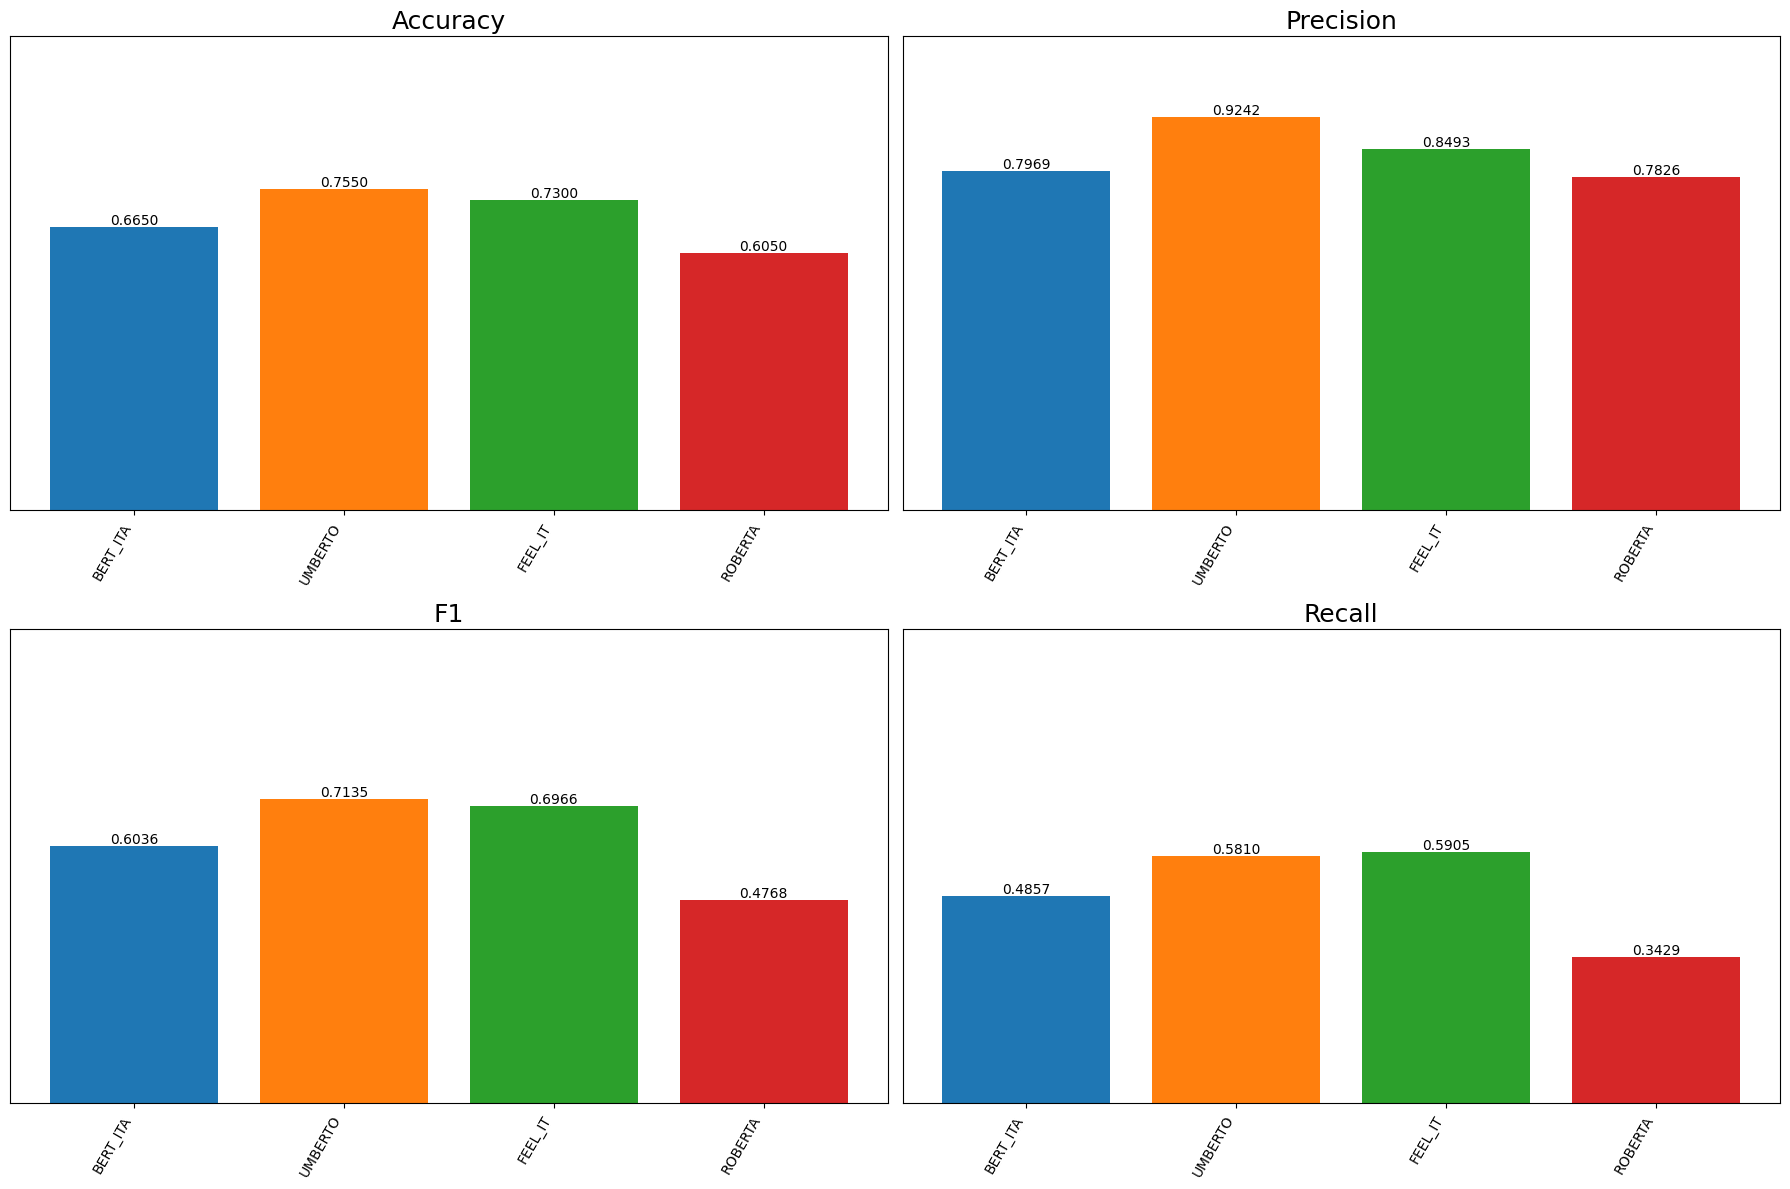

In [95]:
height1 = [metrics5['accuracy'],  metrics6['accuracy'],  metrics7['accuracy'],  metrics8['accuracy']]
height2 = [metrics5['precision'], metrics6['precision'], metrics7['precision'], metrics8['precision']]
height3 = [metrics5['f1'],        metrics6['f1'],        metrics7['f1'],        metrics8['f1']]
height4 = [metrics5['recall'],    metrics6['recall'],    metrics7['recall'],    metrics8['recall']]
labels = ['BERT_ITA', 'UMBERTO', 'FEEL_IT', 'ROBERTA']

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.bar(labels, height=height1, color=colors)
for rect in bars1:
     height = rect.get_height()
     ax1.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
bars2 = ax2.bar(labels, height=height2, color=colors)
for rect in bars2:
     height = rect.get_height()
     ax2.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
bars3 = ax3.bar(labels, height=height3, color=colors)
for rect in bars3:
     height = rect.get_height()
     ax3.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
bars4 = ax4.bar(labels, height=height4, color=colors)
for rect in bars4:
     height = rect.get_height()
     ax4.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])
ax1.set_title('Accuracy', fontsize = 18)
ax2.set_title('Precision', fontsize = 18)
ax3.set_title('F1', fontsize = 18)
ax4.set_title('Recall', fontsize = 18)
ax1.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax2.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax3.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax4.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax1.set_xticklabels(labels, rotation = 60, ha="right")
ax2.set_xticklabels(labels, rotation = 60, ha="right")
ax3.set_xticklabels(labels, rotation = 60, ha="right")
ax4.set_xticklabels(labels, rotation = 60, ha="right")
plt.tight_layout()
plt.show()

In [97]:
print(''.join(['> ' for i in range(40)]))
print(f'\n{"MODEL":<25}{"METRICS MEAN":>18}\n')
print(''.join(['> ' for i in range(40)]))
print(f'{"BERT_ITA++:":<25}{np.mean([i for i in metrics5.values()]):>18.3f}')
print(f'\033[1m{"UMBERTO++:":<25}\033[0m\033[1m{np.mean([i for i in metrics6.values()]):>18.3f}\033[0m')
print(f'{"FEEL_IT++:":<25}{np.mean([i for i in metrics7.values()]):>18.3f}')
print(f'{"ROBERTA++:":<25}{np.mean([i for i in metrics8.values()]):>18.3f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

MODEL                          METRICS MEAN

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
BERT_ITA++:                           0.638
UMBERTO++:                            0.743
FEEL_IT++:                            0.717
ROBERTA++:                            0.552
